In [1]:
!pip install spacy

In [2]:
!pip install pandas-datareader

In [3]:
!pip install keras

In [4]:
!pip install dash

In [3]:
!pip install pymongo

In [77]:
!pip install --upgrade tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4848 sha256=34d82fb8f47c18e2fd768105a15d8f4a282c0e551b9ffac3f6dc98a6933ae97b
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns

from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from pymongo import MongoClient

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def connect_mongodb(host, port, username, password, dbName):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, dbName)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[dbName]


def read_collection(db, collection, query={}):
    """ Read from Mongo and Store into DataFrame """
    "Default: localhost, port: 27017"
    # Connect to MongoDB
    #db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    return df

def read_candles(period, assetName):
    db = connect_mongodb("localhost", 27017, "", "", "trady")
    df = read_collection(db, "TradeCandles", {"Period": period, "AssetName": assetName})

    df = df.loc[:, ["OpenTime", "CloseTime", "AssetName", "Period", "HighPrice", "LowPrice", "OpenPrice", "ClosePrice", "Volume", "NumberTrades"]]
    df["HighPrice"] = df["HighPrice"].astype('float')
    df["LowPrice"] = df["LowPrice"].astype('float')
    df["OpenPrice"] = df["OpenPrice"].astype('float')
    df["ClosePrice"] = df["ClosePrice"].astype('float')


    df["BienDo"] = df["HighPrice"] - df["LowPrice"]
    df["%BienDo"] = df["BienDo"]/df["ClosePrice"]*100

    df["OpenTime"] = pd.to_datetime(df['OpenTime']) + pd.DateOffset(hours=7)
    df["CloseTime"] = pd.to_datetime(df['CloseTime']) + pd.DateOffset(hours=7)

    df["OpenTime"] = pd.to_datetime(df['OpenTime'], format='%Y-%m-%d')
    df["CloseTime"] = pd.to_datetime(df['OpenTime'], format='%Y-%m-%d')
    
    df.rename(columns={"ClosePrice": "Close", "HighPrice": "High", "LowPrice": "Low", "OpenPrice": "Open"}, inplace=True)
    
    return df

def read_assets():
    db = connect_mongodb("localhost", 27017, "", "", "trady")
    query = {"Name": { "$regex": 'USDT$' }}
    df = read_collection(db, "TradeAssets", query)
    return df

def insert_ana_asset(ana):
    db = connect_mongodb("localhost", 27017, "", "", "trady")
    anaCollection = db["AnaAssets"]

    #mydict = { "AssetName": "BTCUSDT", "Period": "Daily", "BullishTypeOfTwoCanldes": "TwoDown", "RateOfPull": 10.1, "RateOfDown": 9.1, "RateOfSideway": 10 }

    x = anaCollection.insert_one(ana)

    return x

In [20]:
def ana_candle_patern(df):
    df["CandlePatern"] = np.nan
    df["BullishType"] = np.nan

    MINIMUM_MIDDLE_RANGE = 0.1
    #MINIMUM_SP_RANGE = 0.4
    
    UP_RANGE = 1/3
    DOWN_RANGE = 2/3
    
    UP_DB_RANGE = 1/5
    DOWN_DB_RANGE = 4/5
    
    length_df = len(df)

    for index, row in df.iterrows():
        op = row["Open"]
        cp = row["Close"]
        hp = row["High"]
        lp = row["Low"]
        tr = row["BienDo"]
        
        if tr == 0: continue

        middle_oc = (op + cp)/2
        tr_middle = abs(hp - middle_oc)
        
        #middle_hl = (hp + lp)/2
        #patern = "N/A"

        #print(index)
        #print("middle_oc:" + str(middle_oc))
        #print("middle_hl:" + str(middle_hl))
        #print("BienDo:" + str(tr))

        if (tr_middle/tr < UP_RANGE):
            #UP
            if (tr_middle/tr < UP_DB_RANGE):
                patern = "UP_DAC_BIET"
            else:
                patern = "UP"
        elif (tr_middle/tr > DOWN_RANGE):
            #DOWN
            if (tr_middle/tr > DOWN_DB_RANGE):
                patern = "DOWN_DAC_BIET"
            else:
                patern = "DOWN"
        else:
            #Cây Middle 
            patern = "MIDDLE"
            
        #if (abs(middle_oc-middle_hl)/tr <= MINIMUM_MIDDLE_RANGE):
            #Cây Middle 
        #    patern = "MIDDLE"
        #elif middle_oc > middle_hl:
        #    #Cây UP
        #    if (abs(hp - middle_oc)/ abs(lp - middle_oc) <= MINIMUM_SP_RANGE):
        #        patern = "UP_DAC_BIET"
        #    else:
        #        patern = "UP"
        #else:
        #    #Cây DOWN
        #    if (abs(lp - middle_oc)/ abs(hp - middle_oc)  <= MINIMUM_SP_RANGE):
        #        patern = "DOWN_DAC_BIET"
        #    else:
        #        patern = "DOWN"

        df.loc[index, 'CandlePatern'] = patern        

        #Bien dong tang hay giam
        if(cp>op):
            df.loc[index, 'BienDong'] = 1 
        elif(cp<op):
            df.loc[index, 'BienDong'] = -1
        else:
            df.loc[index, 'BienDong'] = 0

        #Cây sau là cây tăng giá hay giảm giá
        cp_next = 0
        if (index < length_df -1):
            cp_next = df.loc[index + 1, "Close"]

            if (abs(cp_next - cp)/tr <= MINIMUM_MIDDLE_RANGE):
                df.loc[index, 'BullishType'] = 0
            elif (cp_next > cp):
                df.loc[index, 'BullishType'] = 1
            else:
                df.loc[index, 'BullishType'] = -1

In [21]:
def ana_twocandles(df):
        
    #df["TwoDown"] = np.nan
    #df["TwoUp"] = np.nan
    #df["TwoUpAndUpDacbiet"] = np.nan
    #df["TwoUpDacbiet"] = np.nan
    #df["TwoDownDacbiet"] = np.nan
    #df["TwoDownAndDownDacbiet"] = np.nan
    df["TwoCandlePatern"] = np.nan
    candle_paterns = ["DOWN", "UP", "UP_DAC_BIET", "DOWN_DAC_BIET", "MIDDLE"]
    
    for index, row in df.iterrows():
                
        if (index == 0):
            continue
        
        for x1 in candle_paterns:
            for x2 in candle_paterns:
                if (df.loc[index, "CandlePatern"] == x1 and df.loc[index - 1, "CandlePatern"] == x2):
                    #df.loc[index, x1 + "@" + x2] = 1
                    df.loc[index, "TwoCandlePatern"] = x1 + "@" + x2
                    #print(x1 + "@" + x2)
        #if (df.loc[index, "CandlePatern"] == df.loc[index - 1, "CandlePatern"] == "DOWN"):
        #    df.loc[index, "TwoDown"] = 1
        #else: 
        #    df.loc[index, "TwoDown"] = 0
        
        #if (df.loc[index, "CandlePatern"] == df.loc[index - 1, "CandlePatern"] == "UP"):
        #    df.loc[index, "TwoUp"] = 1
        #else: 
        #    df.loc[index, "TwoUp"] = 0
        
        #if (df.loc[index, "CandlePatern"] == df.loc[index - 1, "CandlePatern"] == "UP_DAC_BIET"):
        #    df.loc[index, "TwoUpDacbiet"] = 1
        #else: 
        #    df.loc[index, "TwoUpDacbiet"] = 0
        
        #if (df.loc[index, "CandlePatern"] == df.loc[index - 1, "CandlePatern"] == "DOWN_DAC_BIET"):
        #    df.loc[index, "TwoDownDacbiet"] = 1
        #else: 
        #    df.loc[index, "TwoDownDacbiet"] = 0
            
        #if ((df.loc[index, "CandlePatern"] ==  "UP" and df.loc[index - 1, "CandlePatern"] == "UP_DAC_BIET") or 
        #    (df.loc[index, "CandlePatern"] ==  "UP_DAC_BIET" and df.loc[index - 1, "CandlePatern"] == "UP")
        #   ):
        #    df.loc[index, "TwoUpAndUpDacbiet"] = 1
        #else: 
        #    df.loc[index, "TwoUpAndUpDacbiet"] = 0
        
        #if ((df.loc[index, "CandlePatern"] ==  "DOWN" and df.loc[index - 1, "CandlePatern"] == "DOWN_DAC_BIET") or
        #    (df.loc[index, "CandlePatern"] ==  "DOWN_DAC_BIET" and df.loc[index - 1, "CandlePatern"] == "DOWN")):
        #    df.loc[index, "TwoDownAndDownDacbiet"] = 1
        #else: 
        #    df.loc[index, "TwoDownAndDownDacbiet"] = 0

In [22]:
def ana_twocandles_bullish(df):
    length_df = len(df)
    MINIMUM_MIDDLE_RANGE = 0.05
    
    df['BullishTypeOfTwoCanldes'] = np.nan
    candle_paterns = ["DOWN", "UP", "UP_DAC_BIET", "DOWN_DAC_BIET", "MIDDLE"]
    
    for index, row in df.iterrows():
        cp_next = 0
        if (index < length_df -1):
            for x1 in candle_paterns:
                for x2 in candle_paterns:
                    if (df.loc[index, "CandlePatern"] == x1 and df.loc[index - 1, "CandlePatern"] == x2):
                        cp = row["Close"]
                        tr = row["BienDo"]

                        cp_next = df.loc[index + 1, "Close"]

                        if (abs(cp_next - cp)/tr <= MINIMUM_MIDDLE_RANGE):
                            df.loc[index, 'BullishTypeOfTwoCanldes'] = "Sideway"
                        elif (cp_next > cp):
                            df.loc[index, 'BullishTypeOfTwoCanldes'] = "Tăng giá"
                        else:
                            df.loc[index, 'BullishTypeOfTwoCanldes'] = "Giảm giá"

In [23]:
def ana_pct_change(df):
    df['PriceChange'] = df["Close"].pct_change().fillna(0)        

In [24]:
def ana_candle_next_partern(df): 
    df["NextCandlePatern"] = np.nan 
    df["BreakHighPrice"] = np.nan
    df["BreakLowPrice"] = np.nan
    
    length_df = df.shape[0]

    for i in range(0,length_df-1):
        df.loc[i, "NextCandlePatern"] = df.loc[i+1, "CandlePatern"]
        df.loc[i, "BreakHighPrice"] = df.loc[i+1, "High"] > df.loc[i, "High"]
        df.loc[i, "BreakLowPrice"] = df.loc[i+1, "Low"] < df.loc[i, "Low"]
        df.loc[i, "Inside"] = df.loc[i+1, "High"] <= df.loc[i, "High"] and df.loc[i+1, "Low"] >= df.loc[i, "Low"]
    #df.loc[i+1, "PriceChange"] = df.loc[i+1, "ClosePrice"] - df.loc[i, "ClosePrice"] 

In [25]:
def normalize_data(df):
    df["BreakHighPrice"] = df["BreakHighPrice"].astype('float')
    df["BreakLowPrice"] = df["BreakLowPrice"].astype('float')
    df["Inside"] = df["Inside"].astype('float')
    df["Volume"] = df["Volume"].astype("float")
    #df["CandlePatern_"] = pd.factorize(df['CandlePatern'])[0]
    #df["TwoCandlePatern_"] = pd.factorize(df['TwoCandlePatern'])[0]

AssetName   ATOMUSDT  AVAXUSDT  FTMUSDT  GALAUSDT  LUNAUSDT  MANAUSDT  NEARUSDT  SANDUSDT
OpenTime                                                                                 
2019-04-29     3.777       NaN      NaN       NaN       NaN       NaN       NaN       NaN
2019-04-30     3.917       NaN      NaN       NaN       NaN       NaN       NaN       NaN
2019-05-01     4.392       NaN      NaN       NaN       NaN       NaN       NaN       NaN
2019-05-02     4.610       NaN      NaN       NaN       NaN       NaN       NaN       NaN
2019-05-03     5.333       NaN      NaN       NaN       NaN       NaN       NaN       NaN
...              ...       ...      ...       ...       ...       ...       ...       ...
2022-02-26    29.880     81.81   1.7707   0.24907     78.13    2.6811     9.117    3.0997
2022-02-27    26.770     75.07   1.5841   0.23194     72.57    2.5576     8.508    2.9000
2022-02-28    31.360     84.54   1.7812   0.26064     91.35    2.8477     9.759    3.2101
2022-03-01

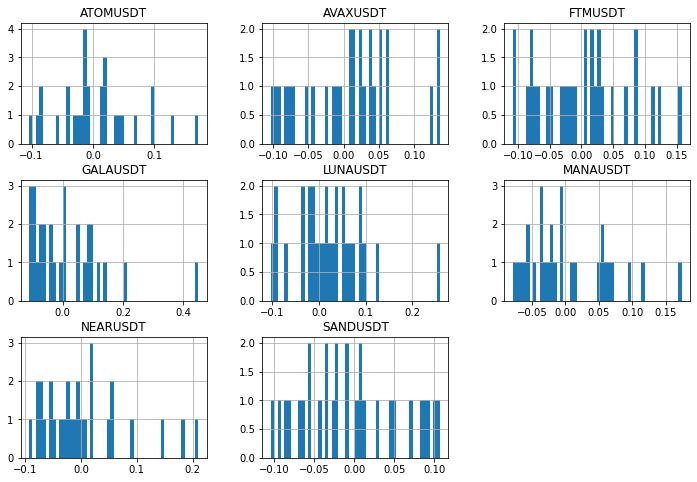

AssetName   ATOMUSDT  AVAXUSDT   FTMUSDT  GALAUSDT  LUNAUSDT  MANAUSDT  NEARUSDT  SANDUSDT
OpenTime                                                                                  
2022-02-01       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN
2022-02-02  0.912275  0.924451  0.927895  0.906239  0.911460  0.946361  0.968959  0.920769
2022-02-03  1.028779  0.933315  0.945765  0.911054  0.980452  0.998771  0.977522  0.927232
2022-02-04  1.078363  1.060548  1.026321  0.981180  1.033538  1.046785  1.158148  1.007795
2022-02-05  1.065534  1.050184  1.008693  1.421777  1.060943  1.121843  1.143074  1.091174
2022-02-06  1.083911  1.076367  1.043321  1.557117  1.074741  1.229084  1.203728  1.167463
2022-02-07  1.096741  1.134597  1.118275  1.692117  1.138559  1.224130  1.204442  1.175031
2022-02-08  1.053745  1.177417  1.063605  1.852648  1.097355  1.292818  1.139773  1.209429
2022-02-09  1.072469  1.228010  1.089056  1.742401  1.102338  1.245809  1.159129  1.185265

In [3]:
def get(tickers):
    def data(ticker):
        return read_candles("Daily", ticker)
    datas = map (data, tickers)
    return(pd.concat(datas, names=['AssetName']))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

tickers = ["NEARUSDT", "AVAXUSDT", "ATOMUSDT", "FTMUSDT", "LUNAUSDT", "GALAUSDT", "MANAUSDT", "SANDUSDT"]
all_df = get(tickers)
all_df.set_index(["AssetName", "OpenTime"], inplace=True)


daily_close_px = all_df[['ClosePrice']].reset_index().pivot('OpenTime', 'AssetName', 'ClosePrice')

#daily_close_px = daily_close_px[-30:]
print(daily_close_px)
# Calculate the daily percentage change for `daily_close_px`
daily_pct_change = daily_close_px[-30:].pct_change()

# Plot the distributions
daily_pct_change.hist(bins=50, figsize=(12,8))

# Show the resulting plot
plt.show()

cum_daily_return = (1 + daily_pct_change).cumprod()
print(cum_daily_return.tail(30))

#df = read_candles("Daily", "NEARUSDT")
#df.set_index('OpenTime', inplace=True)
#sample = df.sample(20)
#print(sample)
#sample = df.resample("M")
#print(sample)

#daily_close =  df["ClosePrice"][-30:]

#daily_pct_change = df["ClosePrice"][-30:].pct_change()
#print(daily_pct_change)

#cum_daily_return = (1 + daily_pct_change).cumprod()
#print(cum_daily_return)
# Plot the distributions
#daily_pct_change.hist(bins=50, figsize=(12,8))

In [73]:
!pip install mplfinance

In [26]:
import talib

df = read_candles("Daily", "BTCUSDT")
ana_candle_patern(df)
ana_twocandles(df)
#ana_twocandles_bullish(df)
ana_pct_change(df)
ana_candle_next_partern(df)
normalize_data(df)

In [16]:
df.describe()
print('Null Values =',df.isnull().values.any())
df[df.columns.values] = df[df.columns.values].ffill()

df.dropna(axis=0, how='all')
df.tail()


Null Values = True


,OpenTime,CloseTime,AssetName,Period,HighPrice,LowPrice,OpenPrice,ClosePrice,Volume,BienDo,%BienDo,CandlePatern,BullishType,BienDong,TwoCandlePatern,PriceChange,NextCandlePatern,BreakHighPrice,BreakLowPrice,Inside,CandlePatern_,TwoCandlePatern_,MFI14,RSI14,MA10,MA20,MA50
39688,2022-03-03 02:00:00,2022-03-03 02:00:00,BTCUSDT,Hourly,43834.94,43593.02,43825.87,43790.01,911.50866,241.92,0.552455,UP_DAC_BIET,-1.0,-1.0,UP_DAC_BIET@MIDDLE,-0.000818,MIDDLE,1.0,1.0,0.0,3,5,54.813419,48.841025,43848.149,43958.2285,43861.4460
39689,2022-03-03 03:00:00,2022-03-03 03:00:00,BTCUSDT,Hourly,43843.25,43193.52,43790.01,43305.77,3968.80311,649.73,1.500331,MIDDLE,1.0,-1.0,MIDDLE@UP_DAC_BIET,-0.011058,MIDDLE,0.0,0.0,1.0,0,9,53.942581,41.682503,43803.708,43924.8625,43862.3634
39690,2022-03-03 04:00:00,2022-03-03 04:00:00,BTCUSDT,Hourly,43481.52,43249.83,43305.76,43435.27,1145.10826,231.69,0.533414,MIDDLE,-1.0,1.0,MIDDLE@MIDDLE,0.002990,MIDDLE,1.0,0.0,0.0,0,0,44.106802,44.044478,43787.235,43904.6265,43867.8686
39691,2022-03-03 05:00:00,2022-03-03 05:00:00,BTCUSDT,Hourly,43505.61,43274.97,43435.27,43316.87,882.76420,230.64,0.532448,MIDDLE,1.0,-1.0,MIDDLE@MIDDLE,-0.002726,UP_DAC_BIET,0.0,1.0,0.0,0,0,15.812340,42.355392,43748.480,43875.0950,43871.2518
39692,2022-03-03 06:00:00,2022-03-03 06:00:00,BTCUSDT,Hourly,43413.75,42915.06,43316.87,43365.22,2009.77431,498.69,1.149977,UP_DAC_BIET,1.0,1.0,UP_DAC_BIET@MIDDLE,0.001116,UP_DAC_BIET,0.0,1.0,0.0,3,5,16.394331,43.311452,43704.671,43836.3835,43871.8310


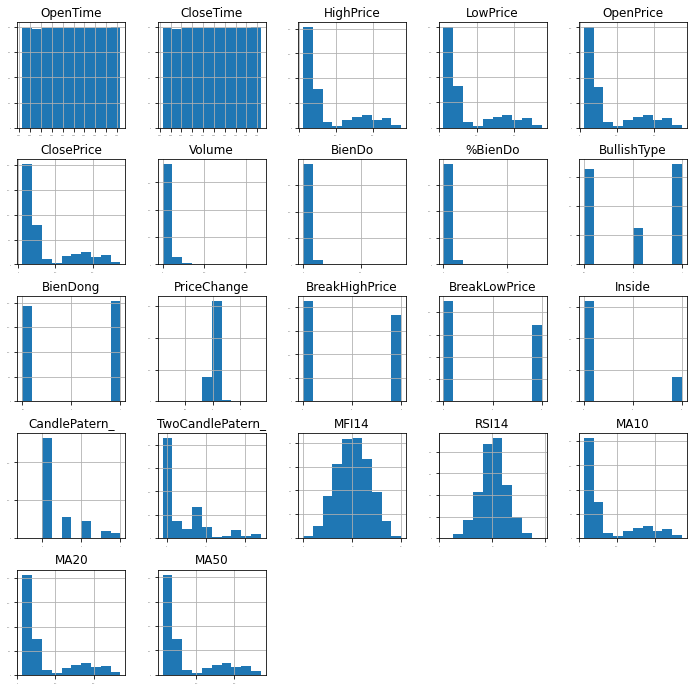

In [25]:
# histograms
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

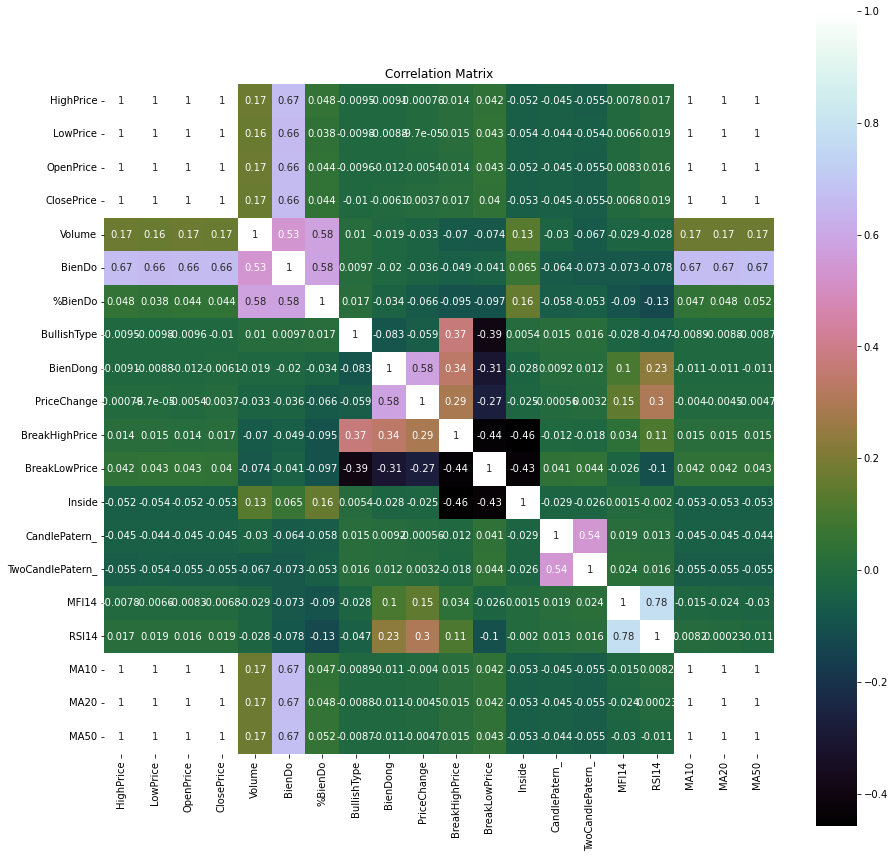

<Figure size 1080x1080 with 0 Axes>

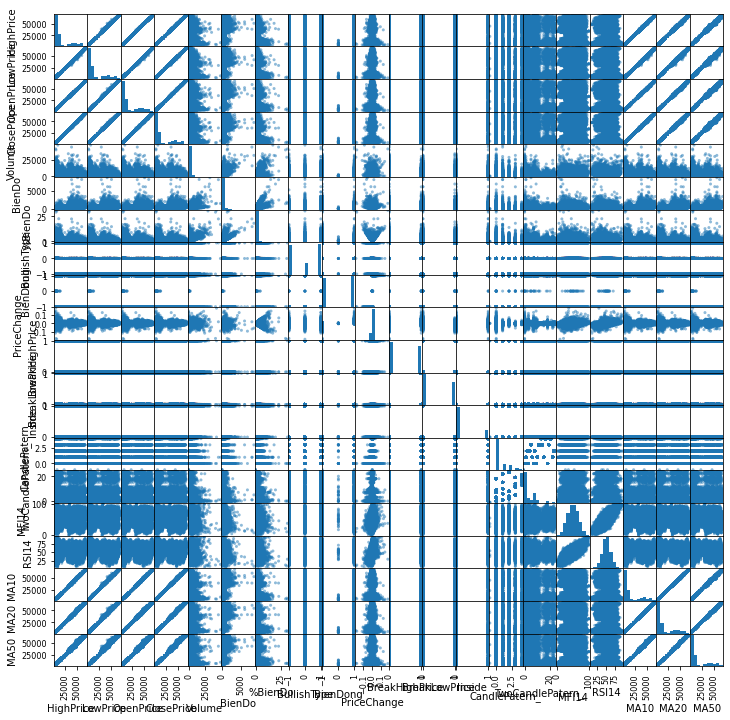

In [27]:
# correlation
correlation = df.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.figure(figsize=(15,15))
scatter_matrix(df,figsize=(12,12))
plt.show()

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

df["MFI14"] = talib.MFI(df["HighPrice"], df["LowPrice"], df["ClosePrice"], df["Volume"], timeperiod=14)
df["RSI14"] = talib.RSI(df["ClosePrice"], 14)
df["MA10"] = talib.MA(df["ClosePrice"], 10)
df["MA20"] = talib.MA(df["ClosePrice"], 20)
df["MA50"] = talib.MA(df["ClosePrice"], 50)


df2 =  df[['ClosePrice', 'Volume', 'BienDong', "PriceChange", 'BullishType', 'BreakHighPrice', 'BreakLowPrice', 'CandlePatern_', 'TwoCandlePatern_', 'MA10', 'MA20', 'MA50',  'MFI14', 'RSI14']]

df2 = df2.dropna(axis=0)


#df2[['ClosePrice']].plot(grid=True)
#plt.show()

# histograms
#df2.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
#plt.show()

#fig = plt.figure()
#plot = df2.groupby(['BreakHighPrice']).size().plot(kind='barh', color='red')
#plt.show()

# correlation
#correlation = df2.corr()
#plt.figure(figsize=(15,15))
#plt.title('Correlation Matrix')
#sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')



LR: 0.586125 (0.017316)
LDA: 0.699875 (0.009395)
KNN: 0.518500 (0.013748)
CART: 0.627250 (0.020477)
NB: 0.697125 (0.010898)
NN: 0.535625 (0.029049)
AB: 0.719625 (0.013886)
GBM: 0.721000 (0.015439)
RF: 0.701375 (0.013812)


In [49]:
def eval_models(df, column_y):
    # split out validation dataset for the end
    subset_dataset= df.iloc[-10000:]
    Y= subset_dataset[column_y]
    X = subset_dataset.loc[:, ((df.columns != 'BreakHighPrice') & (df.columns != 'BreakLowPrice')& (df.columns != 'BullishType'))]
    validation_size = 0.2
    seed = 1
    num_folds = 10
    seed = 7
    scoring = 'accuracy'

    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

    scaler = StandardScaler().fit(X_train)
    rescaledX_train = scaler.transform(X_train)

    #from sklearn.preprocessing import StandardScaler
    #scaler = StandardScaler().fit(X_train)
    #rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
    # summarize transformed data
    #X_train.dropna(how='any', inplace=True)
    #rescaledDataset.dropna(how='any', inplace=True)
    #rescaledDataset.head(2)

    models = []
    models.append(('LR', LogisticRegression(n_jobs=-1)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    #Neural Network
    models.append(('NN', MLPClassifier()))
    #Ensable Models 
    # Boosting methods
    models.append(('AB', AdaBoostClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    # Bagging methods
    models.append(('RF', RandomForestClassifier(n_jobs=-1)))

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
        cv_results = cross_val_score(model, rescaledX_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return models

In [50]:
eval_models(df2, 'BreakLowPrice')

LR: 0.701750 (0.014971)
LDA: 0.698250 (0.015362)
KNN: 0.675625 (0.014919)
CART: 0.626625 (0.024071)
NB: 0.693500 (0.015112)


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multi

NN: 0.707875 (0.020179)
AB: 0.715500 (0.012945)
GBM: 0.726625 (0.014780)
RF: 0.703250 (0.014644)


[('LR', LogisticRegression(n_jobs=-1)),
 ('LDA', LinearDiscriminantAnalysis()),
 ('KNN', KNeighborsClassifier()),
 ('CART', DecisionTreeClassifier()),
 ('NB', GaussianNB()),
 ('NN', MLPClassifier()),
 ('AB', AdaBoostClassifier()),
 ('GBM', GradientBoostingClassifier()),
 ('RF', RandomForestClassifier(n_jobs=-1))]

In [51]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

n_estimators = [20,80]
max_depth= [5,10]
learning_rate = [0.1, 0.3]

#criterion = ["gini","entropy"]

param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate = learning_rate )

#gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
#param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch1.fit(train[predictors],train[target])

model = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.725500 using {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 80}
#6 0.717750 (0.013250) with: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 20}
#1 0.725500 (0.014729) with: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 80}
#4 0.720875 (0.012870) with: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 20}
#2 0.724000 (0.012347) with: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 80}
#3 0.723000 (0.013302) with: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 20}
#5 0.718125 (0.013956) with: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 80}
#7 0.716250 (0.013727) with: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 20}
#8 0.699500 (0.015127) with: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 80}


In [52]:
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 80, max_depth=5, min_samples_split=500,min_samples_leaf=50,max_features='sqrt',subsample=0.8,random_state=10) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)



GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                           min_samples_leaf=50, min_samples_split=500,
                           n_estimators=80, random_state=10, subsample=0.8)

In [53]:
import pickle

# save the model to disk
filename = 'finalized_model_GB_BreakLowPrice.sav'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)

NameError: name 'X_test' is not defined

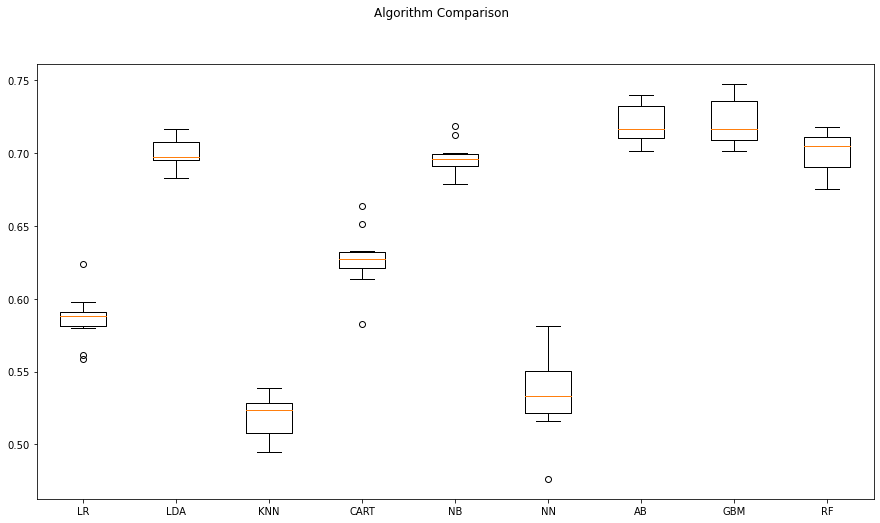

In [24]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
# summarize transformed data
X_train.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

,ClosePrice,Volume,BienDong,PriceChange,CandlePatern_,TwoCandlePatern_,MA10,MA20,MA50,MFI14,RSI14
32387,1.064456,-0.308127,-1.00778,-0.460972,0.444882,3.444534,1.080221,1.113718,1.146933,-0.932074,-0.589203
34833,-0.239520,-0.357796,-1.00778,-0.377768,1.442095,0.828278,-0.171229,-0.119911,-0.106184,-0.547037,-1.720963


Variance preserved by first 5 components == 91.32%


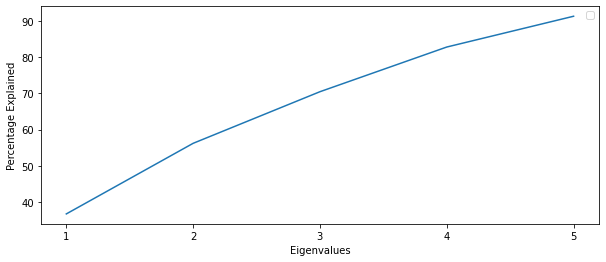

In [35]:
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import TruncatedSVD

ncomps = 5
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(rescaledDataset)
ax = plt_data.plot(kind='line', figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Percentage Explained")
ax.legend("")
print('Variance preserved by first 5 components == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [43]:
dfsvd = pd.DataFrame(Y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledDataset.index)
print(dfsvd.shape)
svdcols = [c for c in dfsvd.columns if c[0] == 'c']
dfsvd.head()




(8000, 5)


,c0,c1,c2,c3,c4
32387,-2.320182,1.423813,2.673937,0.401854,-0.254208
34833,0.273960,1.778740,1.642535,0.387287,-0.535462
32261,-1.544333,-1.080972,-0.589772,0.110098,-0.136886
33364,2.250828,1.823139,1.623054,0.469864,-0.668839
37120,-3.526529,3.657962,0.055503,1.279585,-0.486063


In [41]:
import time

# test options for classification
scoring = 'accuracy'
start_time = time.time()
# spot check the algorithms
models =  RandomForestClassifier(n_jobs=-1)
cv_results_XTrain= cross_val_score(models, X_train, Y_train, cv=kfold, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))
#Time Without Dimensionality Reduction--- 7.781347990036011 seconds ---

start_time = time.time()
X_SVD= dfsvd[svdcols].iloc[:,:5]
cv_results_SVD = cross_val_score(models, X_SVD, Y_train, cv=kfold, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))
#Time with Dimensionality Reduction--- 2.281977653503418 seconds ---
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Time Without Dimensionality Reduction--- 1.3852596282958984 seconds ---
Time with Dimensionality Reduction--- 1.2951788902282715 seconds ---
Result without dimensionality Reduction: 0.701500 (0.015008)
Result with dimensionality Reduction: 0.688625 (0.013584)


In [20]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
#model = LinearDiscriminantAnalysis()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.717500 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#7 0.711375 (0.008560) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.711625 (0.009922) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.714000 (0.010765) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#2 0.717000 (0.012109) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#5 0.712125 (0.011539) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#4 0.712750 (0.010545) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#8 0.710750 (0.012884) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.717500 (0.014577) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [47]:
model = RandomForestClassifier(criterion='entropy', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=80,
                       n_jobs=-1)

In [48]:
# estimate accuracy on validation set
rescaledX_validation = scaler.transform(X_validation)
#predictions = model.predict(rescaledX_validation)
predictions = model.predict(X_validation)


print(predictions)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

[1. 1. 1. ... 1. 1. 1.]
0.694
[[743 309]
 [303 645]]
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71      1052
         1.0       0.68      0.68      0.68       948

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000



In [136]:
x_val = df2.tail(1)
x_val = x_val.loc[:, df2.columns != 'BreakHighPrice']

predict = model.predict(x_val)

print(predict)



[1.]


In [46]:
import pickle

# save the model to disk
filename = 'finalized_model_RF_BreakHighPrice.sav'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)


In [131]:
x_val = df2.tail(1)
x_val = x_val.loc[:, df2.columns != 'BreakLowPrice']

predict = model.predict(x_val)

print(predict)

[0.]


Text(0.5, 0, 'Variable Importance')

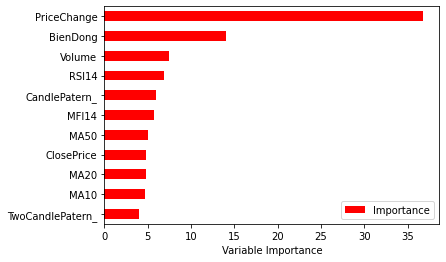

In [23]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

In [96]:
df2.tail()

,ClosePrice,Volume,BienDong,PriceChange,BreakHighPrice,BreakLowPrice,CandlePatern_,TwoCandlePatern_,MA10,MA20,MA50,MFI14,RSI14
1652,38327.21,120476.29458,1.0,0.028918,0.0,0.0,1,0,39819.033,41344.3065,40485.2532,24.582845,42.383109
1653,39219.17,56574.57125,1.0,0.023272,1.0,0.0,1,3,39286.464,41236.1355,40407.9904,33.217050,45.969604
1654,39116.72,29361.25680,-1.0,-0.002612,0.0,1.0,1,3,38810.780,41072.9280,40358.9952,37.840485,45.618358
1655,37699.07,46229.44719,-1.0,-0.036242,1.0,0.0,1,3,38529.117,40765.8820,40279.3818,36.348453,40.955092
1656,43160.00,73945.63858,1.0,0.144856,1.0,0.0,1,3,38847.673,40721.7325,40305.2894,40.151308,58.537782


In [30]:
from sklearn.preprocessing import OrdinalEncoder
# define ordinal encoding
encoder = OrdinalEncoder()
# transform data

a = encoder.fit_transform(df["CandlePatern"].reshape(-1, 1))

#result = encoder.fit_transform(df["CandlePatern"])


AttributeError: 'Series' object has no attribute 'reshape'

In [118]:
df.tail()

,OpenTime,CloseTime,AssetName,Period,HighPrice,LowPrice,OpenPrice,ClosePrice,Volume,BienDo,%BienDo,CandlePatern,BullishType,BienDong,TwoCandlePatern,PriceChange,NextCandlePatern,BreakHighPrice,BreakLowPrice,Inside,CandlePatern_,TwoCandlePatern_
1654,2022-02-26,2022-02-26,BTCUSDT,Daily,40348.45,38573.18,39219.16,39116.72,29361.25680,1775.27,4.538392,MIDDLE,Giảm giá,-1.0,MIDDLE@MIDDLE,-0.002612,MIDDLE,0.0,1.0,0.0,1,3
1655,2022-02-27,2022-02-27,BTCUSDT,Daily,39855.70,37000.00,39116.73,37699.07,46229.44719,2855.70,7.574988,MIDDLE,Tăng giá,-1.0,MIDDLE@MIDDLE,-0.036242,MIDDLE,1.0,0.0,0.0,1,3
1656,2022-02-28,2022-02-28,BTCUSDT,Daily,44225.84,37450.17,37699.08,43160.00,73945.63858,6775.67,15.698957,MIDDLE,Tăng giá,1.0,MIDDLE@MIDDLE,0.144856,MIDDLE,1.0,0.0,0.0,1,3
1657,2022-03-01,2022-03-01,BTCUSDT,Daily,44949.00,42809.98,43160.00,44421.20,61743.09873,2139.02,4.815313,MIDDLE,Giảm giá,1.0,MIDDLE@MIDDLE,0.029222,MIDDLE,0.0,0.0,1.0,1,3
1658,2022-03-02,2022-03-02,BTCUSDT,Daily,44750.00,43653.63,44421.20,44153.20,21327.33328,1096.37,2.483104,MIDDLE,NaN,-1.0,MIDDLE@MIDDLE,-0.006033,NaN,NaN,NaN,NaN,1,3


<AxesSubplot:>

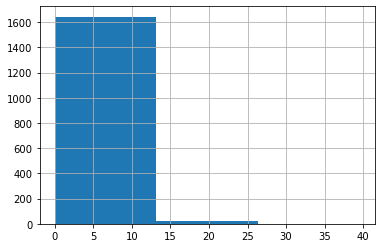

In [35]:
df["PriceChangeABS"].hist(bins=3)

In [50]:
df["CandlePatern_"] = pd.factorize(df['CandlePatern'])[0]
df["NextCandlePatern_"] = pd.factorize(df['NextCandlePatern'])[0]

df["TwoCandlePatern_"] = pd.factorize(df['TwoCandlePatern'])[0]

df["BreakHighPrice_"] = pd.factorize(df['BreakHighPrice'])[0]


df2 = df[df["TwoCandlePatern_"] > 0]
df2.head(20)


,OpenTime,CloseTime,AssetName,Period,HighPrice,LowPrice,OpenPrice,ClosePrice,Volume,BienDo,%BienDo,CandlePatern,BullishType,BienDong,TwoCandlePatern,MIDDLE@DOWN,UP_DAC_BIET@MIDDLE,MIDDLE@UP_DAC_BIET,MIDDLE@MIDDLE,DOWN@UP_DAC_BIET,DOWN@MIDDLE,UP_DAC_BIET@DOWN,UP@MIDDLE,MIDDLE@UP,DOWN_DAC_BIET@UP_DAC_BIET,MIDDLE@DOWN_DAC_BIET,UP@UP,DOWN@DOWN,UP@UP_DAC_BIET,DOWN_DAC_BIET@UP,UP_DAC_BIET@DOWN_DAC_BIET,UP@DOWN,DOWN@UP,DOWN_DAC_BIET@MIDDLE,DOWN@DOWN_DAC_BIET,UP_DAC_BIET@UP,DOWN_DAC_BIET@DOWN,UP@DOWN_DAC_BIET,PriceChange,NextCandlePatern,BreakHighPrice,BreakLowPrice,Inside,CandlePatern_,TwoCandlePatern_,NextCandlePatern_,BreakHighPrice_
2,2017-08-19,2017-08-19,BTCUSDT,Daily,4184.69,3850.00,4108.37,4139.98,381.30976300,334.69,8.084339,UP_DAC_BIET,Giảm giá,1.0,UP_DAC_BIET@MIDDLE,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,True,False,False,2,1,0,1
3,2017-08-20,2017-08-20,BTCUSDT,Daily,4211.08,4032.62,4120.98,4086.29,467.08302200,178.46,4.367287,MIDDLE,Giảm giá,-1.0,MIDDLE@UP_DAC_BIET,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,True,False,1,2,0,0
4,2017-08-21,2017-08-21,BTCUSDT,Daily,4119.62,3911.79,4069.13,4016.00,691.74306000,207.83,5.175050,MIDDLE,Tăng giá,-1.0,MIDDLE@MIDDLE,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,UP_DAC_BIET,False,True,False,1,3,1,0
5,2017-08-22,2017-08-22,BTCUSDT,Daily,4104.82,3400.00,4016.00,4040.00,966.68485800,704.82,17.446040,UP_DAC_BIET,Tăng giá,1.0,UP_DAC_BIET@MIDDLE,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,DOWN,True,False,False,2,1,2,1
6,2017-08-23,2017-08-23,BTCUSDT,Daily,4265.80,4013.89,4040.00,4114.01,1001.13656500,251.91,6.123223,DOWN,Tăng giá,1.0,DOWN@UP_DAC_BIET,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,True,False,False,0,4,0,1
8,2017-08-25,2017-08-25,BTCUSDT,Daily,4453.91,4247.48,4316.01,4280.68,573.61274000,206.43,4.822365,DOWN,Tăng giá,-1.0,DOWN@MIDDLE,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,True,False,0,5,0,0
10,2017-08-27,2017-08-27,BTCUSDT,Daily,4400.00,4285.54,4332.51,4310.01,350.69258500,114.46,2.655678,DOWN,Tăng giá,-1.0,DOWN@MIDDLE,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,UP_DAC_BIET,False,True,False,0,5,1,0
11,2017-08-28,2017-08-28,BTCUSDT,Daily,4399.82,4124.54,4310.01,4386.69,603.84161600,275.28,6.275347,UP_DAC_BIET,Tăng giá,1.0,UP_DAC_BIET@DOWN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,True,False,False,2,6,0,1
12,2017-08-29,2017-08-29,BTCUSDT,Daily,4625.85,4313.55,4353.65,4587.48,603.54502800,312.30,6.807659,MIDDLE,Giảm giá,1.0,MIDDLE@UP_DAC_BIET,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,True,False,False,1,2,0,1
13,2017-08-30,2017-08-30,BTCUSDT,Daily,4647.51,4416.01,4564.52,4555.14,808.46877100,231.50,5.082171,MIDDLE,Tăng giá,-1.0,MIDDLE@MIDDLE,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,True,False,False,1,3,0,1


In [12]:
df['PriceChange'] = abs(df["ClosePrice"].pct_change().fillna(0))

In [53]:
df[df["DOWN_DAC_BIET@UP_DAC_BIET"] == 1].groupby("BullishType").mean()

df2 = df[df["DOWN_DAC_BIET@UP_DAC_BIET"] == 1].groupby("BullishType")
df3 = df2.size().to_frame('Count')
df3.reset_index(inplace=True)

df3.pivot(columns='BullishType', values='Count')
df3[df3["BullishType"] == "Giảm giá"]["Count"]

candle_paterns = ["DOWN", "UP", "UP_DAC_BIET", "DOWN_DAC_BIET", "MIDDLE"]
for x1 in candle_paterns:
    for x2 in candle_paterns:
        df2 = df[df[x1 + "@" + x2] == 1].size().to_frame('Count')


0    1
Name: Count, dtype: int64

In [93]:
df[df["DOWN_DAC_BIET@UP_DAC_BIET"] == 1].groupby("BullishType").mean()

df2 = df[df["DOWN_DAC_BIET@UP_DAC_BIET"] == 1].groupby("BullishType")
type(df2.size())

df3 = pd.DataFrame({"CandlePatern": "DOWN_DAC_BIET@UP_DAC_BIET",
                    "Count":df2.size()})
df3.reset_index(inplace=True)
#df3.reindex(columns=['CandlePatern'], axis="columns")
df3.set_index('CandlePatern', inplace=True)

df3["Percent"] = (df3["Count"]/df3["Count"].sum())*100
df3.head()
#df3 = df2.size().to_frame('Count')
#df3.reset_index(inplace=True)

#print(df3)
df3.pivot(columns='BullishType')

Count           Percent         
BullishType               Giảm giá Tăng giá Giảm giá Tăng giá
CandlePatern                                                 
DOWN_DAC_BIET@UP_DAC_BIET        1        1     50.0     50.0

In [27]:
import talib

df = read_candles("Daily", "BTCUSDT")
ana_candle_patern(df)
ana_twocandles(df)
#ana_twocandles_bullish(df)
ana_pct_change(df)
ana_candle_next_partern(df)
normalize_data(df)

In [28]:
def ana_two_candle(patern):
    if patern in df.columns:
        df2 = df[df[patern] == 1].groupby("NextCandlePatern")
        df3 = pd.DataFrame({"TwoCandlePatern": patern,"Count":df2.size()})
        df3.reset_index(inplace=True)
        df3.set_index('TwoCandlePatern', inplace=True)
        df3["Percent"] = (df3["Count"]/df3["Count"].sum())*100
        return df3    
def ana_two_candles(paterns):
    datas = map (ana_two_candle, paterns)
    return(pd.concat(datas, names=['TwoCandlePatern']))

In [29]:
df_dummies = pd.get_dummies(df["TwoCandlePatern"])


df = pd.concat([df, df_dummies], axis=1)


In [30]:
df.tail(20)

,OpenTime,CloseTime,AssetName,Period,High,Low,Open,Close,Volume,NumberTrades,BienDo,%BienDo,CandlePatern,BullishType,BienDong,TwoCandlePatern,PriceChange,NextCandlePatern,BreakHighPrice,BreakLowPrice,Inside,DOWN@DOWN,DOWN@DOWN_DAC_BIET,DOWN@MIDDLE,DOWN@UP,DOWN@UP_DAC_BIET,DOWN_DAC_BIET@DOWN,DOWN_DAC_BIET@MIDDLE,DOWN_DAC_BIET@UP,DOWN_DAC_BIET@UP_DAC_BIET,MIDDLE@DOWN,MIDDLE@DOWN_DAC_BIET,MIDDLE@MIDDLE,MIDDLE@UP,MIDDLE@UP_DAC_BIET,UP@DOWN,UP@DOWN_DAC_BIET,UP@MIDDLE,UP@UP,UP@UP_DAC_BIET,UP_DAC_BIET@DOWN,UP_DAC_BIET@DOWN_DAC_BIET,UP_DAC_BIET@MIDDLE,UP_DAC_BIET@UP
1646,2022-02-18,2022-02-18,BTCUSDT,Daily,40959.88,39450.00,40515.71,39974.44,43845.92241,0,1509.88,3.777114,MIDDLE,0.0,-1.0,MIDDLE@MIDDLE,-0.013359,MIDDLE,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1647,2022-02-19,2022-02-19,BTCUSDT,Daily,40444.32,39639.03,39974.45,40079.17,18042.05510,0,805.29,2.009248,MIDDLE,-1.0,1.0,MIDDLE@MIDDLE,0.002620,MIDDLE,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1648,2022-02-20,2022-02-20,BTCUSDT,Daily,40125.44,38000.00,40079.17,38386.89,33439.29011,0,2125.44,5.536890,MIDDLE,-1.0,-1.0,MIDDLE@MIDDLE,-0.042223,DOWN,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1649,2022-02-21,2022-02-21,BTCUSDT,Daily,39494.35,36800.00,38386.89,37008.16,62347.68496,0,2694.35,7.280421,DOWN,1.0,-1.0,DOWN@MIDDLE,-0.035917,MIDDLE,0.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1650,2022-02-22,2022-02-22,BTCUSDT,Daily,38429.00,36350.00,37008.16,38230.33,53785.94589,0,2079.00,5.438091,MIDDLE,-1.0,1.0,MIDDLE@DOWN,0.033024,DOWN,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1651,2022-02-23,2022-02-23,BTCUSDT,Daily,39249.93,37036.79,38230.33,37250.01,43560.73200,0,2213.14,5.941314,DOWN,1.0,-1.0,DOWN@MIDDLE,-0.025642,MIDDLE,1.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1652,2022-02-24,2022-02-24,BTCUSDT,Daily,39843.00,34322.28,37250.02,38327.21,120476.29458,0,5520.72,14.404179,MIDDLE,1.0,1.0,MIDDLE@DOWN,0.028918,MIDDLE,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1653,2022-02-25,2022-02-25,BTCUSDT,Daily,39683.53,38014.37,38328.68,39219.17,56574.57125,0,1669.16,4.255980,MIDDLE,0.0,1.0,MIDDLE@MIDDLE,0.023272,MIDDLE,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1654,2022-02-26,2022-02-26,BTCUSDT,Daily,40348.45,38573.18,39219.16,39116.72,29361.25680,0,1775.27,4.538392,MIDDLE,-1.0,-1.0,MIDDLE@MIDDLE,-0.002612,MIDDLE,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1655,2022-02-27,2022-02-27,BTCUSDT,Daily,39855.70,37000.00,39116.73,37699.07,46229.44719,0,2855.70,7.574988,MIDDLE,1.0,-1.0,MIDDLE@MIDDLE,-0.036242,MIDDLE,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

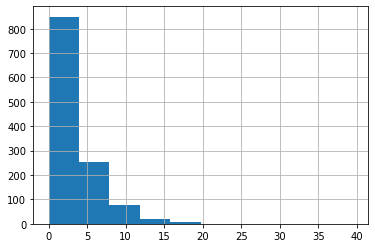

In [49]:
#df["PriceChangeABS"].hist(bins=5)

df[(df["CandlePatern"] == "MIDDLE")]["PriceChangeABS"].hist(bins=10)

In [18]:
candle_paterns = ["DOWN", "UP", "UP_DAC_BIET", "DOWN_DAC_BIET", "MIDDLE"]
list_paterns =[]
for x1 in candle_paterns:
    for x2 in candle_paterns:
        list_paterns.append(x1 + "@" + x2)

print(list_paterns)
df_ana = ana_two_candles(list_paterns)

df_ana.pivot(columns='NextCandlePatern').fillna(0)

['DOWN@DOWN', 'DOWN@UP', 'DOWN@UP_DAC_BIET', 'DOWN@DOWN_DAC_BIET', 'DOWN@MIDDLE', 'UP@DOWN', 'UP@UP', 'UP@UP_DAC_BIET', 'UP@DOWN_DAC_BIET', 'UP@MIDDLE', 'UP_DAC_BIET@DOWN', 'UP_DAC_BIET@UP', 'UP_DAC_BIET@UP_DAC_BIET', 'UP_DAC_BIET@DOWN_DAC_BIET', 'UP_DAC_BIET@MIDDLE', 'DOWN_DAC_BIET@DOWN', 'DOWN_DAC_BIET@UP', 'DOWN_DAC_BIET@UP_DAC_BIET', 'DOWN_DAC_BIET@DOWN_DAC_BIET', 'DOWN_DAC_BIET@MIDDLE', 'MIDDLE@DOWN', 'MIDDLE@UP', 'MIDDLE@UP_DAC_BIET', 'MIDDLE@DOWN_DAC_BIET', 'MIDDLE@MIDDLE']


Count                                           Percent                                                  
NextCandlePatern      DOWN DOWN_DAC_BIET MIDDLE    UP UP_DAC_BIET       DOWN DOWN_DAC_BIET      MIDDLE          UP UP_DAC_BIET
TwoCandlePatern                                                                                                               
DOWN@DOWN              0.0           0.0    0.0   2.0         0.0   0.000000      0.000000    0.000000  100.000000    0.000000
DOWN@DOWN_DAC_BIET     0.0           0.0    1.0   0.0         0.0   0.000000      0.000000  100.000000    0.000000    0.000000
DOWN@MIDDLE            2.0           0.0    9.0   2.0         0.0  15.384615      0.000000   69.230769   15.384615    0.000000
DOWN@UP                0.0           0.0    2.0   0.0         0.0   0.000000      0.000000  100.000000    0.000000    0.000000
DOWN_DAC_BIET@MIDDLE   1.0           0.0    5.0   0.0         0.0  16.666667      0.000000   83.333333    0.000000    0.000000
DOWN_DAC_BIET@UP       0.0           0.0    1.0   0.0         0.0   0.000000      0.000000  100.000000    0.000000    0.000000
MIDDLE@DOWN            0.0           1.0    8.0   3.0         0.0   0.000000      8.333333   66.666667   25.000000    0.000000
MIDDLE@DOWN_DAC_BIET   1.0           1.0    2.0   1.0         1.0  16.666667     16.666667   33.333333   16.666667   16.666667
MIDDLE@MIDDLE          9.0           2.0   90.0  14.0         3.0   7.627119      1.694915   76.271186   11.864407    2.542373
MIDDLE@UP              3.0           3.0   13.0   6.0         1.0  11.538462     11.538462   50.000000   23.076923    3.846154
MIDDLE@UP_DAC_BIET     0.0           0.0    5.0   1.0         2.0   0.000000      0.000000   62.500000   12.500000   25.000000
UP@DOWN                0.0           0.0    3.0   1.0         0.0   0.000000      0.000000   75.000000   25.000000    0.000000
UP@MIDDLE              2.0           1.0   21.0   1.0         1.0   7.692308      3.846154   80.769231    3.846154    3.846154
UP@UP                  0.0           0.0    2.0   1.0         0.0   0.000000      0.000000   66.666667   33.333333    0.000000
UP_DAC_BIET@MIDDLE     0.0           0.0    7.0   0.0         0.0   0.000000      0.000000  100.000000    0.000000    0.000000
UP_DAC_BIET@UP         0.0           0.0    1.0   0.0         0.0   0.000000      0.000000  100.000000    0.000000    0.000000

In [36]:
df[(df["CandlePatern"] == "MIDDLE")]["PriceChangeABS"].describe()

#df["PriceChangeABS"] = abs(df["PriceChange"])*100
   

count    1209.000000
mean        3.275930
std         3.285214
min         0.004564
25%         0.943620
50%         2.327224
75%         4.512549
max        39.504847
Name: PriceChangeABS, dtype: float64

In [42]:
print(df[((df["OpenTime"] > "2021-07-25") & (df["OpenTime"] < "2021-10-01"))][["OpenTime", "CandlePatern"]])

       OpenTime   CandlePatern
1439 2021-07-26           DOWN
1440 2021-07-27         MIDDLE
1441 2021-07-28         MIDDLE
1442 2021-07-29         MIDDLE
1443 2021-07-30             UP
1444 2021-07-31         MIDDLE
1445 2021-08-01         MIDDLE
1446 2021-08-02         MIDDLE
1447 2021-08-03         MIDDLE
1448 2021-08-04         MIDDLE
1449 2021-08-05             UP
1450 2021-08-06         MIDDLE
1451 2021-08-07         MIDDLE
1452 2021-08-08         MIDDLE
1453 2021-08-09         MIDDLE
1454 2021-08-10         MIDDLE
1455 2021-08-11  DOWN_DAC_BIET
1456 2021-08-12         MIDDLE
1457 2021-08-13         MIDDLE
1458 2021-08-14             UP
1459 2021-08-15    UP_DAC_BIET
1460 2021-08-16           DOWN
1461 2021-08-17           DOWN
1462 2021-08-18           DOWN
1463 2021-08-19         MIDDLE
1464 2021-08-20         MIDDLE
1465 2021-08-21         MIDDLE
1466 2021-08-22             UP
1467 2021-08-23           DOWN
1468 2021-08-24         MIDDLE
1469 2021-08-25         MIDDLE
1470 202

In [ ]:
df[(df["CandlePatern"] == "MIDDLE") & (df["Next"])]["PriceChangeABS"].describe()


In [113]:
df["Volume"].astype("float")

0          795.150377
1         1199.888264
2          381.309763
3          467.083022
4          691.743060
            ...      
1652    120476.294580
1653     56574.571250
1654     29361.256800
1655     46229.447190
1656     21221.993390
Name: Volume, Length: 1657, dtype: float64

In [138]:
df["BreakHighPrice"] = df["BreakHighPrice"].astype('float')
df["BreakLowPrice"] = df["BreakLowPrice"].astype('float')
df["Inside"] = df["Inside"].astype('float')
df["Volume"] = df["Volume"].astype("float")

#df["BreakHighPrice"].fillna(0)
#df["BreakLowPrice"].fillna(0)
#df["Inside"].fillna(0)CandlePatern

In [139]:
print(df.isnull().sum())

OpenTime                        0
CloseTime                       0
AssetName                       0
Period                          0
HighPrice                       0
LowPrice                        0
OpenPrice                       0
ClosePrice                      0
Volume                          0
BienDo                          0
%BienDo                         0
CandlePatern                    0
BullishType                     1
BienDong                        0
TwoCandlePatern                 0
MIDDLE@DOWN                  1577
UP_DAC_BIET@MIDDLE           1611
MIDDLE@UP_DAC_BIET           1616
MIDDLE@MIDDLE                 776
DOWN@UP_DAC_BIET             1654
DOWN@MIDDLE                  1572
UP_DAC_BIET@DOWN             1650
UP@MIDDLE                    1486
MIDDLE@UP                    1474
DOWN_DAC_BIET@UP_DAC_BIET    1656
MIDDLE@DOWN_DAC_BIET         1642
UP@UP                        1616
DOWN@DOWN                    1651
UP@UP_DAC_BIET               1642
DOWN_DAC_BIET@

In [141]:
df[df["TwoCandlePatern"].isnull() == True]

,OpenTime,CloseTime,AssetName,Period,HighPrice,LowPrice,OpenPrice,ClosePrice,Volume,BienDo,%BienDo,CandlePatern,BullishType,BienDong,TwoCandlePatern,MIDDLE@DOWN,UP_DAC_BIET@MIDDLE,MIDDLE@UP_DAC_BIET,MIDDLE@MIDDLE,DOWN@UP_DAC_BIET,DOWN@MIDDLE,UP_DAC_BIET@DOWN,UP@MIDDLE,MIDDLE@UP,DOWN_DAC_BIET@UP_DAC_BIET,MIDDLE@DOWN_DAC_BIET,UP@UP,DOWN@DOWN,UP@UP_DAC_BIET,DOWN_DAC_BIET@UP,UP_DAC_BIET@DOWN_DAC_BIET,UP@DOWN,DOWN@UP,DOWN_DAC_BIET@MIDDLE,DOWN@DOWN_DAC_BIET,UP_DAC_BIET@UP,DOWN_DAC_BIET@DOWN,UP@DOWN_DAC_BIET,PriceChange,NextCandlePatern,BreakHighPrice,BreakLowPrice,Inside


In [103]:
df2 = df[df["UP_DAC_BIET@UP_DAC_BIET"] == 1]

KeyError: 'UP_DAC_BIET@UP_DAC_BIET'

In [19]:
df[45:]

,OpenTime,CloseTime,AssetName,Period,HighPrice,LowPrice,OpenPrice,ClosePrice,Volume,BienDo,%BienDo,CandlePatern,BullishType,BienDong,TwoDown,TwoUp,TwoUpAndUpDacbiet,TwoUpDacbiet,TwoDownDacbiet,TwoDownAndDownDacbiet,MIDDLEDOWN,UP_DAC_BIETMIDDLE,MIDDLEUP_DAC_BIET,MIDDLEMIDDLE,DOWNUP_DAC_BIET,DOWNMIDDLE,UP_DAC_BIETDOWN,UPMIDDLE,MIDDLEUP,DOWN_DAC_BIETUP_DAC_BIET,MIDDLEDOWN_DAC_BIET,UPUP,DOWNDOWN,UPUP_DAC_BIET,DOWN_DAC_BIETUP,UP_DAC_BIETDOWN_DAC_BIET,UPDOWN,DOWNUP,DOWN_DAC_BIETMIDDLE,DOWNDOWN_DAC_BIET,UP_DAC_BIETUP,DOWN_DAC_BIETDOWN,UPDOWN_DAC_BIET,PriceChange,NextCandlePatern,BreakHighPrice,BreakLowPrice,Inside
45,2017-10-01,2017-10-01,BTCUSDT,Daily,4406.52,4240.04,4378.49,4378.48,726.96368500,166.48,3.802233,UP_DAC_BIET,Sideway,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,DOWN_DAC_BIET,True,False,False
46,2017-10-02,2017-10-02,BTCUSDT,Daily,4561.63,4360.00,4400.00,4380.00,655.75697400,201.63,4.603425,DOWN_DAC_BIET,Giảm giá,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,True,False
47,2017-10-03,2017-10-03,BTCUSDT,Daily,4467.33,4180.80,4380.00,4310.00,1082.32356300,286.53,6.648028,MIDDLE,Giảm giá,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,True,False
48,2017-10-04,2017-10-04,BTCUSDT,Daily,4373.00,4142.00,4314.90,4208.59,868.46510100,231.00,5.488774,MIDDLE,Tăng giá,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,True,False
49,2017-10-05,2017-10-05,BTCUSDT,Daily,4355.00,4110.00,4208.59,4292.43,779.13863800,245.00,5.707723,MIDDLE,Tăng giá,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652,2022-02-24,2022-02-24,BTCUSDT,Daily,39843.00,34322.28,37250.02,38327.21,120476.29458000,5520.72,14.404179,MIDDLE,Tăng giá,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,False,True
1653,2022-02-25,2022-02-25,BTCUSDT,Daily,39683.53,38014.37,38328.68,39219.17,56574.57125000,1669.16,4.255980,MIDDLE,Sideway,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,True,False,False
1654,2022-02-26,2022-02-26,BTCUSDT,Daily,40348.45,38573.18,39219.16,39116.72,29361.25680000,1775.27,4.538392,MIDDLE,Giảm giá,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,True,False
1655,2022-02-27,2022-02-27,BTCUSDT,Daily,39855.70,37000.00,39116.73,37699.07,46229.44719000,2855.70,7.574988,MIDDLE,Tăng giá,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,False,True


In [14]:
df[df["Inside"] == True]

,OpenTime,CloseTime,AssetName,Period,HighPrice,LowPrice,OpenPrice,ClosePrice,Volume,BienDo,%BienDo,CandlePatern,BullishType,BienDong,TwoDown,TwoUp,TwoUpAndUpDacbiet,TwoUpDacbiet,TwoDownDacbiet,TwoDownAndDownDacbiet,MIDDLEDOWN,UP_DAC_BIETMIDDLE,MIDDLEUP_DAC_BIET,MIDDLEMIDDLE,DOWNUP_DAC_BIET,DOWNMIDDLE,UP_DAC_BIETDOWN,UPMIDDLE,MIDDLEUP,DOWN_DAC_BIETUP_DAC_BIET,MIDDLEDOWN_DAC_BIET,UPUP,DOWNDOWN,UPUP_DAC_BIET,DOWN_DAC_BIETUP,UP_DAC_BIETDOWN_DAC_BIET,UPDOWN,DOWNUP,DOWN_DAC_BIETMIDDLE,DOWNDOWN_DAC_BIET,UP_DAC_BIETUP,DOWN_DAC_BIETDOWN,UPDOWN_DAC_BIET,PriceChange,NextCandlePatern,BreakHighPrice,BreakLowPrice,Inside
16,2017-09-02,2017-09-02,BTCUSDT,Daily,4939.19,4286.87,4796.16,4472.14,929.14859500,652.32,14.586305,MIDDLE,Sideway,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,False,True
22,2017-09-08,2017-09-08,BTCUSDT,Daily,4735.39,4028.93,4691.66,4282.80,1132.25504600,706.46,16.495283,MIDDLE,Sideway,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,False,True
30,2017-09-16,2017-09-16,BTCUSDT,Daily,3950.00,3470.66,3674.01,3714.95,1297.56395300,479.34,12.903000,MIDDLE,Sideway,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,UP,False,False,True
32,2017-09-18,2017-09-18,BTCUSDT,Daily,4123.20,3690.00,3690.00,4035.01,1030.00645500,433.20,10.736033,MIDDLE,Giảm giá,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,False,True
37,2017-09-23,2017-09-23,BTCUSDT,Daily,3817.19,3542.91,3595.88,3780.00,752.79279100,274.28,7.256085,MIDDLE,Giảm giá,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,False,True
39,2017-09-25,2017-09-25,BTCUSDT,Daily,3979.87,3653.69,3660.02,3920.75,727.99471300,326.18,8.319327,MIDDLE,Giảm giá,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,False,True
54,2017-10-10,2017-10-10,BTCUSDT,Daily,4960.00,4680.59,4786.95,4783.06,1043.22177300,279.41,5.841658,MIDDLE,Tăng giá,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,False,True
59,2017-10-15,2017-10-15,BTCUSDT,Daily,5922.30,5400.01,5855.03,5709.99,1343.52337500,522.29,9.146951,UP,Sideway,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,UP,False,False,True
83,2017-11-08,2017-11-08,BTCUSDT,Daily,7770.02,6651.00,7070.00,7303.00,2822.29880200,1119.02,15.322744,MIDDLE,Giảm giá,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,False,True
88,2017-11-13,2017-11-13,BTCUSDT,Daily,6697.47,5699.99,5839.94,6465.99,2621.24303900,997.48,15.426563,MIDDLE,Tăng giá,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,MIDDLE,False,False,True


In [50]:
df.pivot(index='OpenTime', columns='CandlePatern', values='NextCandlePatern')

CandlePatern,DOWN,DOWN_DAC_BIET,MIDDLE,UP,UP_DAC_BIET
OpenTime,,,,,
2017-08-17,NaN,MIDDLE,NaN,NaN,NaN
2017-08-18,NaN,NaN,UP_DAC_BIET,NaN,NaN
2017-08-19,NaN,NaN,NaN,NaN,DOWN
2017-08-20,UP,NaN,NaN,NaN,NaN
2017-08-21,NaN,NaN,NaN,UP_DAC_BIET,NaN
...,...,...,...,...,...
2022-02-24,NaN,NaN,NaN,MIDDLE,NaN
2022-02-25,NaN,NaN,DOWN,NaN,NaN
2022-02-26,MIDDLE,NaN,NaN,NaN,NaN


TypeError: Image data of dtype object cannot be converted to float

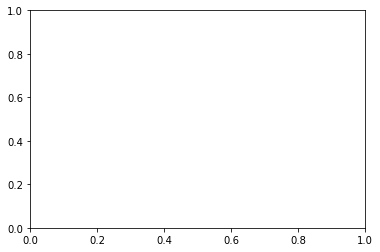

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot using a color palette

pivot_df = df.pivot(index='OpenTime', columns='CandlePatern', values='NextCandlePatern')

plt.pcolor(pivot_df, cmap="YlGnBu")
plt.show()

#sns.heatmap(pivot_df, cmap="YlGnBu")
#plt.show()

In [43]:
df[df["CandlePatern"] == "DOWN"]["NextCandlePatern"].value_counts()

MIDDLE           107
UP                35
UP_DAC_BIET       22
DOWN              17
DOWN_DAC_BIET      6
Name: NextCandlePatern, dtype: int64

In [45]:
df[df["CandlePatern"] == "DOWN_DAC_BIET"]["NextCandlePatern"].value_counts()

MIDDLE           44
UP_DAC_BIET      15
UP               14
DOWN             10
DOWN_DAC_BIET     3
Name: NextCandlePatern, dtype: int64

In [9]:
df_assets = read_assets()
  
twoCanldesTypes = ["TwoDown", "TwoUp", "TwoUpAndUpDacbiet", "TwoUpDacbiet", "TwoDownDacbiet", "TwoDownAndDownDacbiet"]
for index, row in df_assets.iterrows():
    #Doc du lieu cua tung cap giao dich
    period = "Daily"
    assetName = row["Name"]
    
    df_ana = read_candles(period, assetName)
    
    print(assetName)
    
    #Bat dau phan tich du lieu
    ana_candle_patern(df_ana)
    ana_twocandles(df_ana)
    ana_twocandles_bullish(df_ana)
    ana_pct_change(df_ana)
    ana_candle_next_partern(df_ana)
    
    for x in twoCanldesTypes:
        df2 = df_ana[df_ana[x] == 1].groupby("BullishTypeOfTwoCanldes")
        df3 = df2.size().to_frame('Count')
        df3.reset_index(inplace=True)
        df3["Percent"] = df3["Count"]/df3["Count"].sum()*100
        
        RateOfPull= RateOfDown = RateOfSideway = 0.0
        CountOfPull = CountOfDown = CountOfSideway = 0.0

        if (df3[df3["BullishTypeOfTwoCanldes"] == "Tăng giá"].shape[0] > 0):
            RateOfPull = df3[df3["BullishTypeOfTwoCanldes"] == "Tăng giá"].iloc[0].Percent
            CountOfPull = int(df3[df3["BullishTypeOfTwoCanldes"] == "Tăng giá"].iloc[0].Count)
            
        if (df3[df3["BullishTypeOfTwoCanldes"] == "Giảm giá"].shape[0] > 0):
            RateOfDown = df3[df3["BullishTypeOfTwoCanldes"] == "Giảm giá"].iloc[0].Percent
            CountOfDown = int(df3[df3["BullishTypeOfTwoCanldes"] == "Giảm giá"].iloc[0].Count)
        
        if (df3[df3["BullishTypeOfTwoCanldes"] == "Sideway"].shape[0] > 0):
            #print("Sideway")
            RateOfSideway = df3[df3["BullishTypeOfTwoCanldes"] == "Sideway"].iloc[0].Percent
            CountOfSideway = int(df3[df3["BullishTypeOfTwoCanldes"] == "Sideway"].iloc[0].Count)

        ana_dict = {"AssetName": assetName, "Period": period, 
                    "BullishTypeOfTwoCanldes": x, "RateOfPull": RateOfPull, 
                    "RateOfDown": RateOfDown, "RateOfSideway": RateOfSideway,
                    "CountOfPull": CountOfPull, "CountOfDown": CountOfDown, 
                    "CountOfSideway": CountOfSideway}
        
        insert_ana_asset(ana_dict)


BTCUSDT
ETHUSDT
BNBUSDT
BCCUSDT
NEOUSDT
LTCUSDT
QTUMUSDT
ADAUSDT
XRPUSDT
EOSUSDT
TUSDUSDT
IOTAUSDT
XLMUSDT
ONTUSDT
TRXUSDT
ETCUSDT
ICXUSDT
VENUSDT
NULSUSDT
VETUSDT
PAXUSDT
BCHABCUSDT
BCHSVUSDT
USDCUSDT
LINKUSDT
WAVESUSDT
BTTUSDT
USDSUSDT
ONGUSDT
HOTUSDT
ZILUSDT
ZRXUSDT
FETUSDT
BATUSDT
XMRUSDT
ZECUSDT
IOSTUSDT
CELRUSDT
DASHUSDT
NANOUSDT
OMGUSDT
THETAUSDT
ENJUSDT
MITHUSDT
MATICUSDT
ATOMUSDT
TFUELUSDT


KeyboardInterrupt: 

def ana_candle_next_partern(df):
    df["NextCandlePatern"] = np.nan
    #df["ContinueUpPrice"] = np.nan
    #df["ContinueDownPrice"] = np.nan
    #df["BreakHighPrice"] = np.nan
    #df["BreakLowPrice"] = np.nan
    #df["NumOfBreak"] = np.nan
    #df["IsInside"] = np.nan
    #df["PriceChange"] = np.nan
    #df["High-Open"] = np.nan
    #df["Open-Low"] = np.nan
    
    length_df = df.shape[0]
    
    for i in range(0,length_df-1):
        df.loc[i, "NextCandlePatern"] = df.loc[i+1, "CandlePatern"]
        #df.loc[i+1, "PriceChange"] = df.loc[i+1, "ClosePrice"] - df.loc[i, "ClosePrice"]    

In [21]:
ana_candle_patern(df)

In [21]:
ana_candle_patern(df)

In [22]:
ana_twocandles(df)

In [23]:
ana_twocandles_bullish(df)

In [ ]:
ana_pct_change()

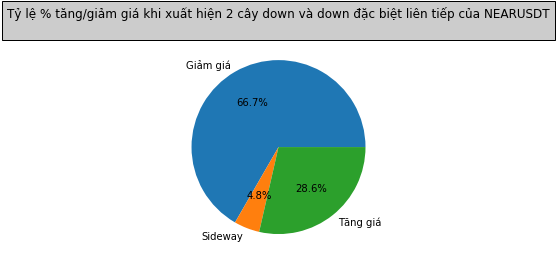

In [31]:
df2 = df[df["TwoDownAndDownDacbiet"] == 1].groupby("BullishTypeOfTwoCanldes")
df3 = df2.size().to_frame('Count')
df3.reset_index(inplace=True)

assetName = df.loc[0, "AssetName"]

lables = df3["BullishTypeOfTwoCanldes"]
plt.pie(df3["Count"], labels=lables, autopct='%1.1f%%')
plt.title("Tỷ lệ % tăng/giảm giá khi xuất hiện 2 cây down và down đặc biệt liên tiếp của " +  assetName + "\n", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

#df3.plot.pie(subplots=True,autopct='%1.1f%%')
#df3

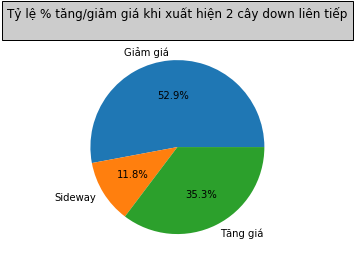

In [27]:
df2 = df[df["TwoDown"] == 1].groupby("BullishTypeOfTwoCanldes")
df3 = df2.size().to_frame('Count')
df3.reset_index(inplace=True)

lables = df3["BullishTypeOfTwoCanldes"]
plt.pie(df3["Count"], labels=lables, autopct='%1.1f%%')
plt.title("Tỷ lệ % tăng/giảm giá khi xuất hiện 2 cây down liên tiếp\n" , bbox={'facecolor':'0.8', 'pad':5})
plt.show()

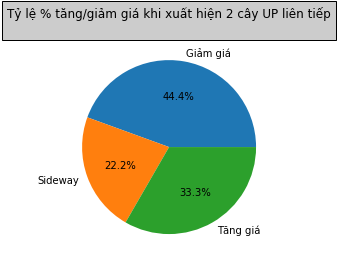

In [11]:
df2 = df[df["TwoUp"] == 1].groupby("BullishTypeOfTwoCanldes")
df3 = df2.size().to_frame('Count')
df3.reset_index(inplace=True)

lables = df3["BullishTypeOfTwoCanldes"]
plt.pie(df3["Count"], labels=lables, autopct='%1.1f%%')
plt.title("Tỷ lệ % tăng/giảm giá khi xuất hiện 2 cây UP liên tiếp\n" , bbox={'facecolor':'0.8', 'pad':5})
plt.show()

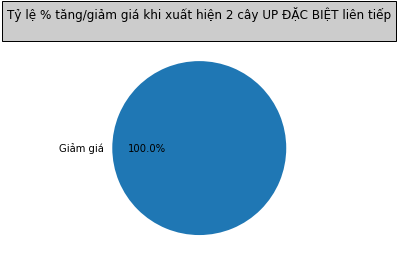

In [12]:
df2 = df[df["TwoUpDacbiet"] == 1].groupby("BullishTypeOfTwoCanldes")
df3 = df2.size().to_frame('Count')
df3.reset_index(inplace=True)
df3["Percent"] = df3["Count"]/df3["Count"].sum()*100

lables = df3["BullishTypeOfTwoCanldes"]
plt.pie(df3["Count"], labels=lables, autopct='%1.1f%%')
plt.title("Tỷ lệ % tăng/giảm giá khi xuất hiện 2 cây UP ĐẶC BIỆT liên tiếp\n" , bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [127]:
#TwoDown TwoDownAndDownDacbiet
df2 = df[df["TwoDown"] == 1].groupby("BullishTypeOfTwoCanldes")
df3 = df2.size().to_frame('Count')
df3.reset_index(inplace=True)
df3["Percent"] = df3["Count"]/df3["Count"].sum()*100
#print(df3)
percent = df3[df3["BullishTypeOfTwoCanldes"] == "Sideway"].iloc[0].Count
print(percent)

2


,Count
BullishType,
Giảm giá,33
Sideway,16
Tăng giá,38


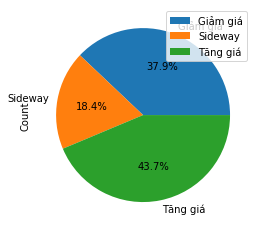

In [66]:
#df2 = df[df["CandlePatern"].str.contains("DOWN")].groupby("BullishType")
df2 = df[df["CandlePatern"] == "DOWN"].groupby("BullishType")

df3 = df2.size().to_frame('Count')
df3.reset_index()

df3.plot.pie(subplots=True,autopct='%1.1f%%')
df3

In [60]:
df[df["OpenTime"] >= "2020-04-27"].head(10)

,OpenTime,CloseTime,AssetName,Period,HighPrice,LowPrice,OpenPrice,ClosePrice,Volume,BienDo,...,CandlePatern,BullishType,BienDong,TwoDown,TwoUp,TwoUpAndUpDacbiet,TwoUpDacbiet,TwoDownDacbiet,TwoDownAndDownDacbiet,BullishTypeOfTwoCanldes
141,2020-04-27,2020-04-27,BTCUSDT,Weekly,9460.00,7606.00,7693.10,8894.16,742165.16210400,1854.00,...,DOWN,Sideway,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
142,2020-05-04,2020-05-04,BTCUSDT,Weekly,10067.00,8117.00,8894.15,8722.77,780478.84946600,1950.00,...,DOWN,Tăng giá,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,Tăng giá
143,2020-05-11,2020-05-11,BTCUSDT,Weekly,9939.00,8200.00,8722.77,9680.04,721487.83708700,1739.00,...,MIDDLE,Giảm giá,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
144,2020-05-18,2020-05-18,BTCUSDT,Weekly,9950.00,8700.00,9681.11,8720.34,517248.17753600,1250.00,...,MIDDLE,Tăng giá,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
145,2020-05-25,2020-05-25,BTCUSDT,Weekly,9740.00,8642.72,8718.14,9448.27,425528.24616700,1097.28,...,MIDDLE,Tăng giá,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
146,2020-06-01,2020-06-01,BTCUSDT,Weekly,10380.00,9266.00,9448.27,9746.99,427822.49534700,1114.00,...,DOWN,Giảm giá,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
147,2020-06-08,2020-06-08,BTCUSDT,Weekly,9992.72,9113.00,9746.99,9342.10,336172.77151700,879.72,...,MIDDLE,Sideway,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
148,2020-06-15,2020-06-15,BTCUSDT,Weekly,9589.00,8910.45,9342.10,9294.69,323565.71184200,678.55,...,UP,Giảm giá,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
149,2020-06-22,2020-06-22,BTCUSDT,Weekly,9780.00,8833.00,9294.69,9116.35,343601.08315400,947.00,...,DOWN,Sideway,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
150,2020-06-29,2020-06-29,BTCUSDT,Weekly,9292.00,8893.03,9116.16,9069.41,247256.19512500,398.97,...,MIDDLE,Tăng giá,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [85]:
df[df["TwoUpDacbiet"] == 1]

,OpenTime,CloseTime,AssetName,Period,HighPrice,LowPrice,OpenPrice,ClosePrice,Volume,BienDo,...,CandlePatern,BullishType,BienDong,TwoDown,TwoUp,TwoUpAndUpDacbiet,TwoUpDacbiet,TwoDownDacbiet,TwoDownAndDownDacbiet,BullishTypeOfTwoCanldes
109,2019-09-16,2019-09-16,BTCUSDT,Weekly,10355.0,9653.0,10303.34,10028.87,188644.19962300,702.0,...,UP_DAC_BIET,Giảm giá,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,Giảm giá


In [25]:
df[df["TwoDownAndDownDacbiet"] == 1].tail(10)

,OpenTime,CloseTime,AssetName,Period,HighPrice,LowPrice,OpenPrice,ClosePrice,Volume,BienDo,...,CandlePatern,BullishType,BienDong,TwoDown,TwoUp,TwoUpAndUpDacbiet,TwoUpDacbiet,TwoDownDacbiet,TwoDownAndDownDacbiet,BullishTypeOfTwoCanldes
292,2021-08-02,2021-08-02,NEARUSDT,Daily,2.4641,2.3211,2.3918,2.3513,4589924.21000000,0.1430,...,DOWN,Sideway,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,Giảm giá
313,2021-08-23,2021-08-23,NEARUSDT,Daily,5.8952,5.3668,5.4536,5.4911,12240971.62000000,0.5284,...,DOWN_DAC_BIET,Giảm giá,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Giảm giá
320,2021-08-30,2021-08-30,NEARUSDT,Daily,5.8880,5.2340,5.5480,5.3240,10821251.90000000,0.6540,...,DOWN,Sideway,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,Giảm giá
324,2021-09-03,2021-09-03,NEARUSDT,Daily,6.8817,5.4800,5.4900,6.1680,23936687.03000000,1.4017,...,DOWN_DAC_BIET,Sideway,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Giảm giá
325,2021-09-04,2021-09-04,NEARUSDT,Daily,6.3770,6.0000,6.1710,6.0770,8897737.40000000,0.3770,...,DOWN,Tăng giá,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,Tăng giá
336,2021-09-15,2021-09-15,NEARUSDT,Daily,9.6700,8.5390,8.6090,9.2420,11966278.60000000,1.1310,...,DOWN,Giảm giá,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Giảm giá
349,2021-09-28,2021-09-28,NEARUSDT,Daily,7.1320,6.3630,6.8900,6.4160,8849791.30000000,0.7690,...,DOWN,Tăng giá,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,Tăng giá
350,2021-09-29,2021-09-29,NEARUSDT,Daily,7.3460,6.3630,6.4200,6.6410,14449088.40000000,0.9830,...,DOWN_DAC_BIET,Tăng giá,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Tăng giá
360,2021-10-09,2021-10-09,NEARUSDT,Daily,8.4200,7.9130,8.1040,8.0390,5144751.30000000,0.5070,...,DOWN,Giảm giá,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,Giảm giá
427,2021-12-15,2021-12-15,NEARUSDT,Daily,17.9500,9.0500,9.3290,9.8450,42680329.33000000,8.9000,...,DOWN_DAC_BIET,Sideway,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Giảm giá


In [377]:
df["OpenTime"] = pd.to_datetime(df['OpenTime'], format='%Y-%m-%d')
df["CloseTime"] = pd.to_datetime(df['OpenTime'], format='%Y-%m-%d')


OpenTime                   datetime64[ns]
CloseTime                  datetime64[ns]
AssetName                          object
Period                             object
HighPrice                         float64
LowPrice                          float64
OpenPrice                         float64
ClosePrice                        float64
Volume                             object
BienDo                            float64
%BienDo                           float64
TwoDown                           float64
TwoUp                             float64
TwoUpAndUpDacbiet                 float64
TwoUpDacbiet                      float64
TwoDownDacbiet                    float64
TwoDownAndDownDacbiet             float64
CandlePatern                       object
BullishType                        object
BienDong                          float64
BullishTypeOfTwoCanldes            object
dtype: object

In [8]:
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns

#Load dataset from csv
dataset = pd.read_csv('TradeCandles.csv')
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')
# shape
dataset.shape
# peek at data
set_option('display.width', 100)
dataset.tail(5)
# describe data
#set_option('precision', 3)
dataset.describe()

,BaseAssetVolume,ClosePrice,HighPrice,LowPrice,NumberTrades,OpenPrice,QuoteAssetVolume,Volume
count,0.0,365.000000,365.000000,365.000000,365.0,365.000000,0.0,365.000000
mean,NaN,47987.629644,49339.878000,46380.372712,0.0,47989.640740,NaN,62483.121095
std,NaN,9174.277347,9278.105336,9078.733458,0.0,9173.172502,NaN,35015.233551
min,NaN,29790.350000,31063.070000,28805.000000,0.0,29790.340000,NaN,7793.135860
25%,NaN,40734.380000,42300.000000,39422.010000,0.0,40734.090000,NaN,40725.088950
50%,NaN,47800.000000,49264.300000,46622.990000,0.0,47799.990000,NaN,53411.753920
75%,NaN,56150.010000,57777.000000,53950.000000,0.0,56150.010000,NaN,77986.694355
max,NaN,67525.830000,69000.000000,66222.400000,0.0,67525.820000,NaN,354347.243161


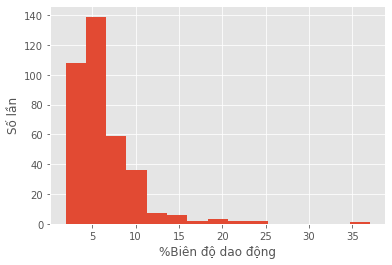

,OpenTime,OpenPrice,ClosePrice,HighPrice,LowPrice,BienDo,IsBullish
16,2021-02-27 00:00:00+00:00,46276.88,46106.43,48394.00,45000.00,3394.00,0.0
22,2021-03-05 00:00:00+00:00,48374.09,48751.71,49448.93,46300.00,3148.93,1.0
23,2021-03-06 00:00:00+00:00,48746.81,48882.20,49200.00,47070.00,2130.00,1.0
36,2021-03-19 00:00:00+00:00,57641.00,58030.01,59468.00,56270.74,3197.26,1.0
37,2021-03-20 00:00:00+00:00,58030.01,58102.28,59880.00,57820.17,2059.83,0.0
40,2021-03-23 00:00:00+00:00,54083.25,54340.89,55830.90,53000.00,2830.90,0.0
45,2021-03-28 00:00:00+00:00,55817.14,55777.63,56559.75,54691.84,1867.91,1.0
48,2021-03-31 00:00:00+00:00,58746.57,58740.55,59800.00,56769.00,3031.00,0.0
49,2021-04-01 00:00:00+00:00,58739.46,58720.44,59490.00,57935.45,1554.55,1.0
50,2021-04-02 00:00:00+00:00,58720.45,58950.01,60200.00,58428.57,1771.43,0.0


In [4]:
#RECOGNIZE PATERN CANDLE

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns

#Load dataset from csv
dataset = pd.read_csv('TradeCandles.csv')
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')
# shape
dataset.shape
# peek at data
set_option('display.width', 100)
dataset.tail(5)
# describe data
#set_option('precision', 3)
dataset.describe()
#Checking for any null values and removing the null values'''
#print('Null Values =',dataset.isnull().values.any())
df = dataset[["AssetName", "OpenPrice", "ClosePrice", "HighPrice", "LowPrice", "Volume", "OpenTime", "CloseTime"]]
df["BienDo"] = df["HighPrice"] - df["LowPrice"]
df["%BienDo"] = df["BienDo"]/df["ClosePrice"]*100
plt.style.use('ggplot')
plt.hist(df[["%BienDo"]], density=False, bins = 15)
plt.ylabel('Số lần')
plt.xlabel('%Biên độ dao động');
plt.show()

df.loc[df["ClosePrice"] > df["OpenPrice"], "BienDong"] = 1
df.loc[df["ClosePrice"] < df["OpenPrice"], "BienDong"] = -1
df.loc[df["ClosePrice"] == df["OpenPrice"], "BienDong"] = 0

candle_names = talib.get_function_groups()['Pattern Recognition']


# extract OHLC 
op = df['OpenPrice']
hi = df['HighPrice']
lo = df['LowPrice']
cl = df['ClosePrice']


for candle in candle_names:
    # below is same as;
    # df["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(op, hi, lo, cl)
    df[candle] = getattr(talib, candle)(op, hi, lo, cl)
df["OpenTime"] = pd.to_datetime(df['OpenTime']) + pd.DateOffset(hours=7)
df["CloseTime"] = pd.to_datetime(df['CloseTime']) + pd.DateOffset(hours=7)
df["IsBullish"] = np.nan

#DROP NA COLUMN
for candle in candle_names:
    df1 = df[df[candle] != 0]
    if (df1["IsBullish"].count() == 0):
        df.drop(candle, axis = 1, inplace = True)
        continue
        
for index, row in df.iterrows():
    if (index == len(df) -1):
        break
    if(df.loc[index, "ClosePrice"] < df.loc[index + 1, "ClosePrice"]):
        df.loc[index, "IsBullish"] = 1
    else:
        df.loc[index, "IsBullish"] = 0
df1 = df[(df["CDLDRAGONFLYDOJI"] > 0) | (df["CDLGRAVESTONEDOJI"] > 0) | (df["CDLDOJI"] > 0)]
df1 = df1.loc[:, ["OpenTime", "OpenPrice", "ClosePrice", "HighPrice", "LowPrice", "BienDo",  "IsBullish"]]
df1.groupby("IsBullish").count()
#df1.hist(column="IsBullish", grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)



In [90]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns

#Load dataset from csv
dataset = pd.read_csv('TradeCandles.csv')
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')
# shape
dataset.shape
# peek at data
set_option('display.width', 100)
dataset.tail(5)
# describe data
#set_option('precision', 3)
dataset.describe()
#Checking for any null values and removing the null values'''
#print('Null Values =',dataset.isnull().values.any())
df = dataset[["AssetName", "OpenPrice", "ClosePrice", "HighPrice", "LowPrice", "Volume", "OpenTime", "CloseTime"]]
df["BienDo"] = df["HighPrice"] - df["LowPrice"]
df["%BienDo"] = df["BienDo"]/df["ClosePrice"]*100

df["OpenTime"] = pd.to_datetime(df['OpenTime']) + pd.DateOffset(hours=7)
df["CloseTime"] = pd.to_datetime(df['CloseTime']) + pd.DateOffset(hours=7)
df["OpenTime"] = df["OpenTime"].dt.date
df["CloseTime"] = df["CloseTime"].dt.date

df["CandlePatern"] = np.nan
df["BullishType"] = np.nan

MINIMUM_MIDDLE_RANGE = 0.02
MINIMUM_SP_RANGE = 0.4
length_df = len(df)

for index, row in df.iterrows():
    op = row["OpenPrice"]
    cp = row["ClosePrice"]
    hp = row["HighPrice"]
    lp = row["LowPrice"]
    tr = row["BienDo"]
    
    middle_oc = (op + cp)/2
    middle_hl = (hp + lp)/2
    patern = "N/A"
    
    print(index)
    print("middle_oc:" + str(middle_oc))
    print("middle_hl:" + str(middle_hl))
    print("BienDo:" + str(tr))

    
    if (abs(middle_oc-middle_hl)/tr <= MINIMUM_MIDDLE_RANGE):
        #Cây Middle 
        patern = "MIDDLE"
    elif middle_oc > middle_hl:
        #Cây UP
        if (abs(hp - middle_oc)/ abs(lp - middle_oc) <= MINIMUM_SP_RANGE):
            patern = "UP_DAC_BIET"
        else:
            patern = "UP"
    else:
        #Cây DOWN
        if (abs(lp - middle_oc)/ abs(hp - middle_oc)  <= MINIMUM_SP_RANGE):
            patern = "DOWN_DAC_BIET"
        else:
            patern = "DOWN"
            
    df.loc[index, 'CandlePatern'] = patern        
    
    #Bien dong tang hay giam
    if(cp>op):
        df.loc[index, 'BienDong'] = 1 
    elif(cp<op):
        df.loc[index, 'BienDong'] = -1
    else:
        df.loc[index, 'BienDong'] = 0
    
    #Cây sau là cây tăng giá hay giảm giá
    cp_next = 0
    if (index < length_df -1):
        cp_next = df.loc[index + 1, "ClosePrice"]
        if (cp_next > cp):
            df.loc[index, 'BullishType'] = "Tăng giá"
        else:
            df.loc[index, 'BullishType'] = "Giảm giá"
    
    print("Patern: " + patern)
    print("-----")

0
middle_oc:46388.545
middle_hl:46336.46
BienDo:4684.880000000005
Patern: MIDDLE
-----
1
middle_oc:47628.130000000005
middle_hl:47555.4
BienDo:2860.800000000003
Patern: UP
-----
2
middle_oc:47225.92
middle_hl:47176.265
BienDo:1947.4700000000012
Patern: UP
-----
3
middle_oc:47867.285
middle_hl:48360.8
BienDo:2693.260000000002
Patern: DOWN
-----
4
middle_oc:48245.785
middle_hl:47290.854999999996
BienDo:3440.1299999999974
Patern: UP_DAC_BIET
-----
5
middle_oc:48522.274999999994
middle_hl:48846.4
BienDo:3685.5599999999977
Patern: DOWN
-----
6
middle_oc:50626.58
middle_hl:50782.869999999995
BienDo:3671.739999999998
Patern: DOWN
-----
7
middle_oc:51835.134999999995
middle_hl:51715.95
BienDo:1628.0999999999985
Patern: UP
-----
8
middle_oc:53729.305
middle_hl:53539.1
BienDo:5657.800000000003
Patern: UP
-----
9
middle_oc:55873.595
middle_hl:55782.195
BienDo:3836.529999999999
Patern: UP
-----
10
middle_oc:56624.880000000005
middle_hl:56915.195
BienDo:2875.2100000000064
Patern: DOWN
-----
11
midd

In [91]:
df.loc[:, ["OpenTime", "OpenPrice","ClosePrice", "HighPrice", "LowPrice", "CandlePatern", "BienDong", "BullishType"]].tail(20)

,OpenTime,OpenPrice,ClosePrice,HighPrice,LowPrice,CandlePatern,BienDong,BullishType
345,2022-01-22,36445.31,35071.42,36835.22,34008.00,UP,-1.0,Tăng giá
346,2022-01-23,35071.42,36244.55,36499.00,34601.01,UP,1.0,Tăng giá
347,2022-01-24,36244.55,36660.35,37550.00,32917.17,UP_DAC_BIET,1.0,Tăng giá
348,2022-01-25,36660.35,36958.32,37545.14,35701.00,UP,1.0,Giảm giá
349,2022-01-26,36958.32,36809.34,38919.98,36234.63,DOWN_DAC_BIET,-1.0,Tăng giá
350,2022-01-27,36807.24,37160.10,37234.47,35507.01,UP_DAC_BIET,1.0,Tăng giá
351,2022-01-28,37160.11,37716.56,38000.00,36155.01,UP,1.0,Tăng giá
352,2022-01-29,37716.57,38166.84,38720.74,37268.44,DOWN,1.0,Giảm giá
353,2022-01-30,38166.83,37881.76,38359.26,37351.63,UP,-1.0,Tăng giá
354,2022-01-31,37881.75,38466.90,38744.00,36632.61,UP_DAC_BIET,1.0,Tăng giá


,Count
BullishType,
Giảm giá,74
Tăng giá,54


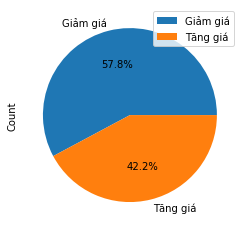

In [92]:
df2 = df[df["CandlePatern"].str.contains("DOWN")].groupby("BullishType")
df3 = df2.size().to_frame('Count')
df3.reset_index()

df3.plot.pie(subplots=True,autopct='%1.1f%%')
df3



#labels = df3["BullishType"]
#sizes = df3["Count"]
#plt.pie(sizes, labels=labels, 
#        autopct='%1.1f%%', shadow=True, startangle=140)
#plt.axis('equal')
#plt.show()


array([<AxesSubplot:ylabel='count'>], dtype=object)

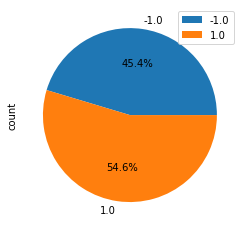

In [88]:
df2 = df[df["CandlePatern"].str.contains("UP")].groupby("BullishType")
df3 = df2.size().to_frame('count')
df3.reset_index()
df3.plot.pie(subplots=True,autopct='%1.1f%%')

<AxesSubplot:ylabel='BullishType'>

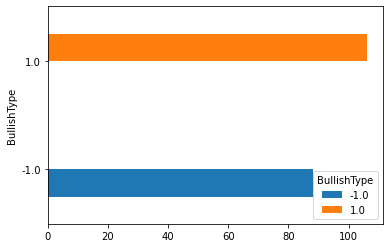

In [66]:
df1.BullishType.value_counts().unstack().plot.barh()

In [266]:
import numpy as np
from candle_rankings import candle_rankings
import talib
from itertools import compress

def recognize_candlestick(df):
    """
    Recognizes candlestick patterns and appends 2 additional columns to df;
    1st - Best Performance candlestick pattern matched by www.thepatternsite.com
    2nd - # of matched patterns
    """

    op = df['open'].astype(float)
    hi = df['high'].astype(float)
    lo = df['low'].astype(float)
    cl = df['close'].astype(float)

    candle_names = talib.get_function_groups()['Pattern Recognition']

    # patterns not found in the patternsite.com
    exclude_items = ('CDLCOUNTERATTACK',
                     'CDLLONGLINE',
                     'CDLSHORTLINE',
                     'CDLSTALLEDPATTERN',
                     'CDLKICKINGBYLENGTH')

    candle_names = [candle for candle in candle_names if candle not in exclude_items]


    # create columns for each candle
    for candle in candle_names:
        # below is same as;
        # df["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(op, hi, lo, cl)
        df[candle] = getattr(talib, candle)(op, hi, lo, cl)


    df['candlestick_pattern'] = np.nan
    df['candlestick_match_count'] = np.nan
    for index, row in df.iterrows():

        # no pattern found
        if len(row[candle_names]) - sum(row[candle_names] == 0) == 0:
            df.loc[index,'candlestick_pattern'] = "NO_PATTERN"
            df.loc[index, 'candlestick_match_count'] = 0
        # single pattern found
        elif len(row[candle_names]) - sum(row[candle_names] == 0) == 1:
            # bull pattern 100 or 200
            if any(row[candle_names].values > 0):
                pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bull'
                df.loc[index, 'candlestick_pattern'] = pattern
                df.loc[index, 'candlestick_match_count'] = 1
            # bear pattern -100 or -200
            else:
                pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bear'
                df.loc[index, 'candlestick_pattern'] = pattern
                df.loc[index, 'candlestick_match_count'] = 1
        # multiple patterns matched -- select best performance
        else:
            # filter out pattern names from bool list of values
            patterns = list(compress(row[candle_names].keys(), row[candle_names].values != 0))
            container = []
            for pattern in patterns:
                if row[pattern] > 0:
                    container.append(pattern + '_Bull')
                else:
                    container.append(pattern + '_Bear')
            rank_list = [candle_rankings[p] for p in container]
            if len(rank_list) == len(container):
                rank_index_best = rank_list.index(min(rank_list))
                df.loc[index, 'candlestick_pattern'] = container[rank_index_best]
                df.loc[index, 'candlestick_match_count'] = len(container)
    # clean up candle columns
    cols_to_drop = candle_names + list(exclude_items)
    df.drop(cols_to_drop, axis = 1, inplace = True)

    return df

CDLDOJI,0,100
IsBullish,153,29


In [9]:
for candle in candle_names:
    df1 = df[df[candle] != 0]
    if (df1["IsBullish"].count() == 0):
        df.drop(candle, axis = 1, inplace = True)
        continue
    print(candle)
    cnt = df1.groupby("IsBullish").size()
    print(cnt)

CDL3INSIDE
IsBullish
0.0    2
1.0    1
dtype: int64
CDL3LINESTRIKE
IsBullish
0.0    1
1.0    1
dtype: int64
CDL3OUTSIDE
IsBullish
0.0     7
1.0    12
dtype: int64
CDLADVANCEBLOCK
IsBullish
0.0    2
1.0    2
dtype: int64
CDLBELTHOLD
IsBullish
0.0    26
1.0    23
dtype: int64
CDLCLOSINGMARUBOZU
IsBullish
0.0    22
1.0    22
dtype: int64
CDLDOJI
IsBullish
0.0    31
1.0    29
dtype: int64
CDLDOJISTAR
IsBullish
0.0    3
dtype: int64
CDLDRAGONFLYDOJI
IsBullish
1.0    4
dtype: int64
CDLENGULFING
IsBullish
0.0    16
1.0    14
dtype: int64
CDLGRAVESTONEDOJI
IsBullish
0.0    4
1.0    2
dtype: int64
CDLHAMMER
IsBullish
1.0    4
dtype: int64
CDLHANGINGMAN
IsBullish
0.0    2
1.0    1
dtype: int64
CDLHARAMI
IsBullish
0.0    9
1.0    6
dtype: int64
CDLHARAMICROSS
IsBullish
0.0    2
1.0    1
dtype: int64
CDLHIGHWAVE
IsBullish
0.0    29
1.0    26
dtype: int64
CDLHIKKAKE
IsBullish
0.0    19
1.0    30
dtype: int64
CDLINVERTEDHAMMER
IsBullish
1.0    1
dtype: int64
CDLLONGLEGGEDDOJI
IsBullish
0.0    31
1.0

In [2]:
df.loc[df["ClosePrice"] > df["OpenPrice"], "BienDong"] = 1

In [3]:
df.loc[df["ClosePrice"] < df["OpenPrice"], "BienDong"] = -1

In [4]:
df.loc[df["ClosePrice"] == df["OpenPrice"], "BienDong"] = 0

In [5]:
df.groupby("BienDong").size()

BienDong
-1.0    182
 1.0    183
dtype: int64

In [7]:
import talib

In [8]:
candle_names = talib.get_function_groups()['Pattern Recognition']

,OpenTime,OpenPrice,HighPrice,LowPrice,ClosePrice,IsBullish
16,2021-03-02 05:00:00+00:00,46276.88,48394.00,45000.00,46106.43,0.0
22,2021-03-08 05:00:00+00:00,48374.09,49448.93,46300.00,48751.71,1.0
23,2021-03-09 05:00:00+00:00,48746.81,49200.00,47070.00,48882.20,1.0
36,2021-03-22 05:00:00+00:00,57641.00,59468.00,56270.74,58030.01,1.0
37,2021-03-23 05:00:00+00:00,58030.01,59880.00,57820.17,58102.28,0.0
40,2021-03-26 05:00:00+00:00,54083.25,55830.90,53000.00,54340.89,0.0
45,2021-03-31 05:00:00+00:00,55817.14,56559.75,54691.84,55777.63,1.0
48,2021-04-03 05:00:00+00:00,58746.57,59800.00,56769.00,58740.55,0.0
49,2021-04-04 05:00:00+00:00,58739.46,59490.00,57935.45,58720.44,1.0
50,2021-04-05 05:00:00+00:00,58720.45,60200.00,58428.57,58950.01,0.0


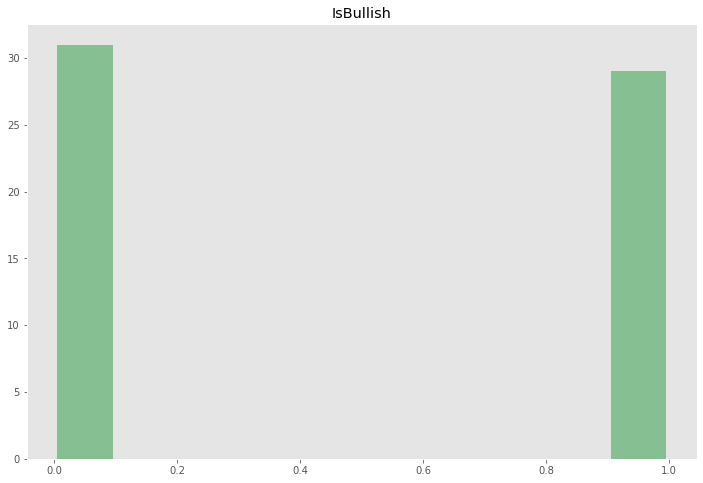

In [253]:
# extract OHLC 
op = df['OpenPrice']
hi = df['HighPrice']
lo = df['LowPrice']
cl = df['ClosePrice']
for candle in candle_names:
    # below is same as;
    # df["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(op, hi, lo, cl)
    df[candle] = getattr(talib, candle)(op, hi, lo, cl)
df["OpenTime"] = pd.to_datetime(df['OpenTime']) + pd.DateOffset(hours=7)
df["CloseTime"] = pd.to_datetime(df['CloseTime']) + pd.DateOffset(hours=7)
df["IsBullish"] = np.nan

for index, row in df.iterrows():
    if (index == len(df) -1):
        break
    if(df.loc[index, "ClosePrice"] < df.loc[index + 1, "ClosePrice"]):
        df.loc[index, "IsBullish"] = 1
    else:
        df.loc[index, "IsBullish"] = 0
df1 = df[(df["CDLDRAGONFLYDOJI"] > 0) | (df["CDLGRAVESTONEDOJI"] > 0) | (df["CDLDOJI"] > 0)]
df1 = df1.loc[:, ["OpenTime", "OpenPrice", "HighPrice", "LowPrice", "ClosePrice", "IsBullish"]]
df1.groupby("IsBullish").count()
df1.hist(column="IsBullish", grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
df1

In [234]:
df1 = df[(df["CDLDRAGONFLYDOJI"] > 0) | (df["CDLGRAVESTONEDOJI"] > 0) | (df["CDLDOJI"] > 0)]
df1["OpenTime"] = pd.to_datetime(df1['OpenTime']) + pd.DateOffset(hours=7)
df1["OpenTime"] = df1["OpenTime"].dt.date
df1 = df1.loc[:, ["OpenTime", "OpenPrice", "HighPrice", "LowPrice", "ClosePrice", "CDLDOJI"]]
#df1.set_index('OpenTime', inplace=True)
df1["IsBullish"] = np.nan
df1.reset_index(drop=True, inplace=True)
df1

,OpenTime,OpenPrice,HighPrice,LowPrice,ClosePrice,CDLDOJI,IsBullish
0,2021-02-27,46276.88,48394.00,45000.00,46106.43,100,NaN
1,2021-03-05,48374.09,49448.93,46300.00,48751.71,100,NaN
2,2021-03-06,48746.81,49200.00,47070.00,48882.20,100,NaN
3,2021-03-19,57641.00,59468.00,56270.74,58030.01,100,NaN
4,2021-03-20,58030.01,59880.00,57820.17,58102.28,100,NaN
5,2021-03-23,54083.25,55830.90,53000.00,54340.89,100,NaN
6,2021-03-28,55817.14,56559.75,54691.84,55777.63,100,NaN
7,2021-03-31,58746.57,59800.00,56769.00,58740.55,100,NaN
8,2021-04-01,58739.46,59490.00,57935.45,58720.44,100,NaN
9,2021-04-02,58720.45,60200.00,58428.57,58950.01,100,NaN


,OpenTime,OpenPrice,HighPrice,LowPrice,ClosePrice,CDLDOJI,IsBullish
0,2021-02-27,46276.88,48394.00,45000.00,46106.43,100,1.0
1,2021-03-05,48374.09,49448.93,46300.00,48751.71,100,1.0
2,2021-03-06,48746.81,49200.00,47070.00,48882.20,100,1.0
3,2021-03-19,57641.00,59468.00,56270.74,58030.01,100,1.0
4,2021-03-20,58030.01,59880.00,57820.17,58102.28,100,0.0
5,2021-03-23,54083.25,55830.90,53000.00,54340.89,100,1.0
6,2021-03-28,55817.14,56559.75,54691.84,55777.63,100,1.0
7,2021-03-31,58746.57,59800.00,56769.00,58740.55,100,0.0
8,2021-04-01,58739.46,59490.00,57935.45,58720.44,100,1.0
9,2021-04-02,58720.45,60200.00,58428.57,58950.01,100,0.0


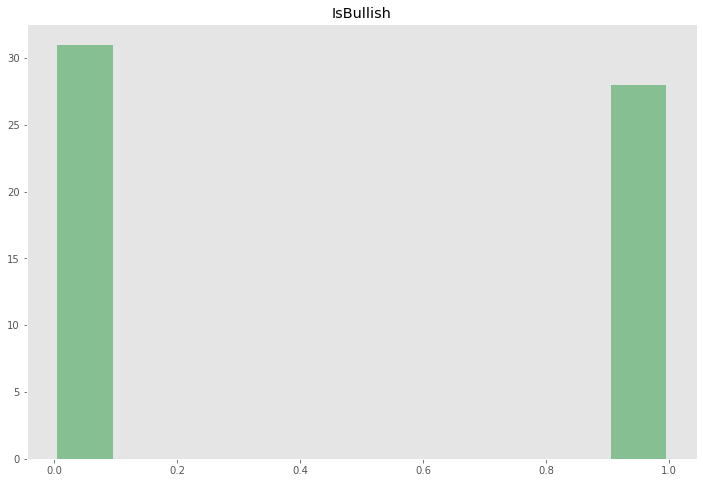

In [241]:
   
for i in range(len(df1)) :
    if (i == len(df1) -1):
        break
    #print(df1[i, 'ClosePrice'])
    if (df1.iloc[i, 4] < df1.iloc[i+1, 4]):
        df1.iloc[i, 6] = 1
    else:
        df1.iloc[i, 6] = 0
df1.groupby("IsBullish").count()

df1.hist(column="IsBullish", grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
df1

In [1]:
from plotly.subplots import make_subplots
from datetime import datetime
import plotly.graph_objects as go

#df = read_candles("Daily", "BTCUSDT")

#df.reset_index(drop=True, inplace=True)



fig = make_subplots(rows=2, cols=1)
fig.append_trace(go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close']), row=1, col=1)
fig.append_trace(go.Scatter(
    x=df.index,
    y=df['NumberTrades'],
), row=2, col=1)

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

NameError: name 'df' is not defined

In [9]:
df.tail()

,OpenTime,CloseTime,AssetName,Period,High,Low,Open,Close,Volume,NumberTrades,BienDo,%BienDo
1658,2022-03-02,2022-03-02,BTCUSDT,Daily,45400.00,43334.09,44421.20,43892.98,57782.65081000,0,2065.91,4.706698
1659,2022-03-03,2022-03-03,BTCUSDT,Daily,44101.12,41832.28,43892.99,42454.00,50940.61021000,0,2268.84,5.344231
1660,2022-03-04,2022-03-04,BTCUSDT,Daily,42527.30,38550.00,42454.00,39148.66,61964.68498000,0,3977.30,10.159479
1661,2022-03-05,2022-03-05,BTCUSDT,Daily,39613.24,38407.59,39148.65,39397.96,30363.13341000,0,1205.65,3.060184
1662,2022-03-06,2022-03-06,BTCUSDT,Daily,39693.87,39345.82,39397.97,39464.59,2094.46710000,0,348.05,0.881930
